In [1]:
#define all relevant functions
import numpy as np
import pandas as pd
from scipy.fft import fftn, ifftn, fftshift
import re

import matplotlib.pyplot as plt

from matplotlib.colors import ListedColormap, BoundaryNorm
import matplotlib.patches as mpatches






def get_data2(model, U,mu, nk, nkf):
    '''
    reads a FRG output text file
    and returns the number of k1 and k2 points used, as well as the data for all three action channels

    '''
  


    df = pd.read_csv(model + "_" + U +"_"+ mu + "_" +f"{nk}" +"_" + f"{nkf}" +".txt", delimiter="\t", header = None, skiprows = 1) 

    r = df.iloc[-1, 0]
    n = r.split()

    tc, sc, mag, cdw, _ = map(float, n)

    
    if sc <= 1e-02 and  mag  <= 1e-02 and cdw <= 1e-02:  # Check if Tc is in the order of magnitude of 10^-6 or smaller
        dominant = 3

    else:
        orders = [sc, mag, cdw]
        o_max = max(orders)
        dominant = orders.index(o_max)
    
    
    return tc, sc, mag, cdw, dominant




def plots(model, nk, nkf, Us, Us_str, mus, mus_str, figna, fignb):

    X, Y = np.meshgrid(mus, Us)
    u_size = len(Us)
    mu_size = len(mus)
    Tcs = np.zeros((u_size,mu_size))
    dom = np.zeros((u_size,mu_size))

    for i, u in enumerate(Us_str):
        for j, mu in enumerate(mus_str):

        
            
            Tcs[i][j] = get_data2(model,u,mu, nk, nkf)[0]
            dom[i][j] = get_data2(model,u, mu, nk, nkf)[4]

    #plot tc


    fig, ax = plt.subplots(figsize=(16, 6))

    #ax.set_aspect('equal')
    ax.grid()
    C = ax.contourf(X, Y, Tcs,  levels = 50, cmap = 'coolwarm', linewidths=1.5)
    fig.colorbar(C, ax=ax, orientation='vertical')

    ax.set_title(f"Fig.{figna}.{fignb}.a 2NN Tc as a function of  U and $\mu$ for nk= {nk} and nkf= {nkf}")
    ax.set_ylabel("U")
    ax.set_xlabel(r"$\mu$")



    colors = ['blue', 'green', 'yellow', 'black']  
    labels = ['SC', 'MAG', 'CDW', 'FL']
    cmap = ListedColormap(colors)
    norm = BoundaryNorm(np.arange(-0.5, 3.5, 1), cmap.N)


    plt.figure(figsize=(8, 6))
    scatter = plt.scatter(X, Y, c=dom, cmap=cmap, norm=norm, s=50, marker = 'x')


    plt.ylabel('U')
    plt.xlabel(r'$\mu$')
    plt.title(f'Fig {figna}.{fignb}.b {model} Phase diagram as a function of U and $\mu$ for nk= {nk} and nkf= {nkf}')

    legend_patches = [mpatches.Patch(color=colors[i], label=labels[i]) for i in range(len(labels))]
    plt.legend(handles=legend_patches, title="Phases", bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.show()
    


In [2]:
Us3 = np.arange(0, 6, 0.25)
mus3 = np.arange(0.0, 1.1 , 0.1)

Us3_str = [f"{x:.2f}" for x in Us3]
mus3_str = [f"{x:.1f}" for x in mus3]

/tmp/ipykernel_13589/1470977866.py:71: UserWarning: linewidths is ignored by contourf
  C = ax.contourf(X, Y, Tcs,  levels = 50, cmap = 'coolwarm', linewidths=1.5)


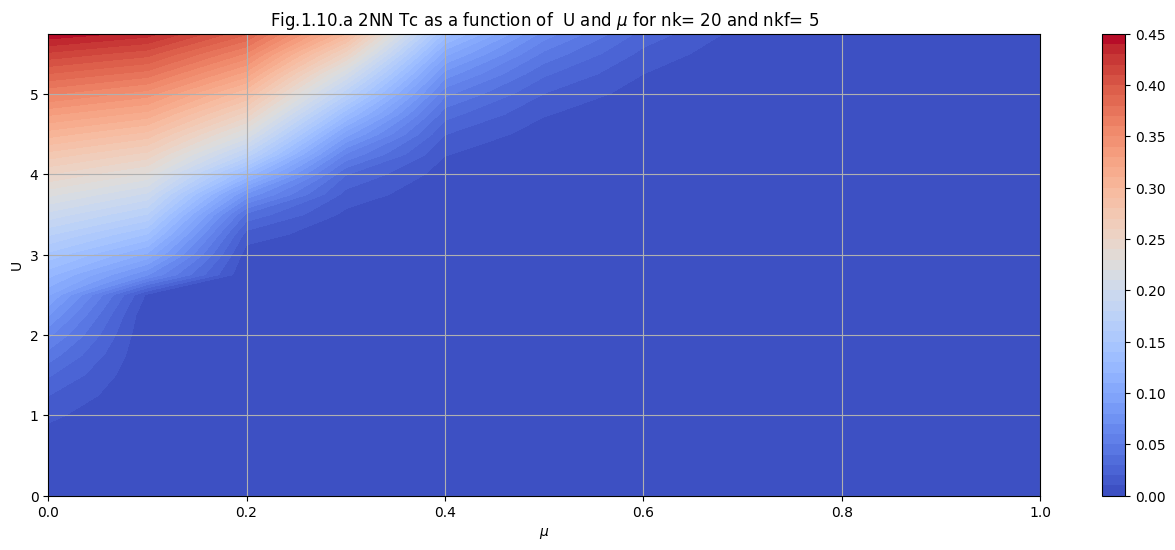

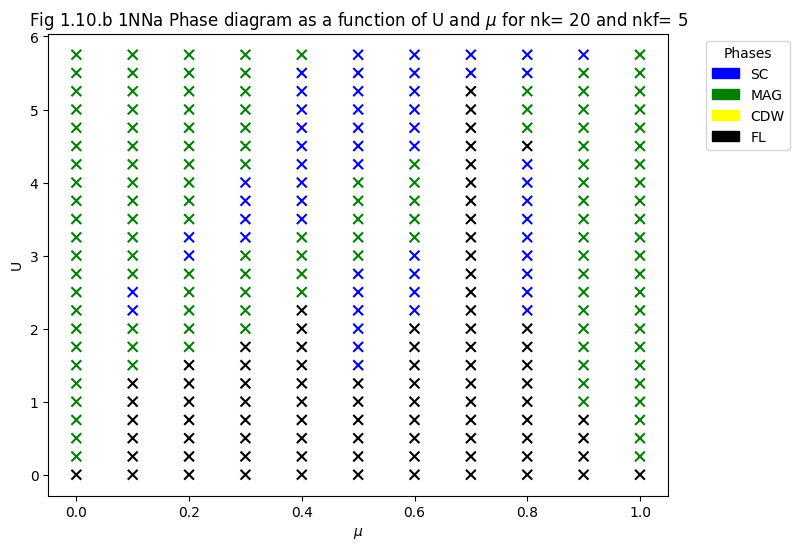

In [3]:
plots(model= "1NNa", nk =20, nkf =5, Us = Us3, Us_str = Us3_str, mus= mus3, mus_str= mus3_str, figna = 1, fignb=10)

In [3]:
def read_data(file_name):
    #This is specific to a file with no headings and in the form of:  k20_kf_5/2NN_0.00_0.0_20_5.out FL 9.01759e-06 1m43.863s
    f = open(file_name, 'r')
    data = []
    for line in f:
        l = line.split()

        if len(l) != 4:
            continue
        else:

            file= l[0].split("/")[-1].split("_") 
            U = float(file[1])  #stores U parameter
            J = float(file[2])  # stores J parameter 
            nk = int(file[3])   #stores nk number points
            nkf = int(file[4].split(".")[0])   #stores nkf number points

            time= l[3].split("m")   #time taken to perform the calculation
            seconds = float(time[0])*60 + float(time[1].split("s")[0])
            final_data = [U, J, nk, nkf,l[1],float(l[2]),seconds]  #l1 and l2 here are the Tc and the dominanting phase
            data.append(final_data)

    return data



In [4]:
import numpy as np
import matplotlib.pyplot as plt
import os
import sys
#from scipy.spatial import ConvexHull
from scipy.spatial import Voronoi, voronoi_plot_2d
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection
import matplotlib.colors as mcolors

def lighten_color(color, factor=0.5):
    """Lighten the given color by a specified factor (0 = same, 1 = white)."""
    rgb = np.array(mcolors.to_rgb(color))
    return mcolors.to_rgba(rgb + (1 - rgb) * factor, alpha=0.5) 

In [6]:





def plot_U_J_Voronoi(inputname,model):
    # print(inputname,outputname,"PYTHON",os.getcwd())
    data = read_data(inputname)
    # Triangular grid
    kb_ev = 8.6173303e-5 #eV
    x = []  #stores Us
    y = []  #stores Js
    groundstate = []
    points = []
    z = []
    for d in data:
        x.append(d[0])
        y.append(d[1])
        points.append([d[0],d[1]])  #U,J vector
        groundstate.append(d[4])  #Stores GS
        z.append((d[5])/kb_ev)  #stores Tc


    #convert ground_State to numbers
    groundstate_num = []
    for i in range(len(groundstate)):
        if groundstate[i] == "FL":
            groundstate_num.append(0)
        elif groundstate[i] == "SC":
            groundstate_num.append(1)
        elif groundstate[i] == "SDW":
            groundstate_num.append(2)
        elif groundstate[i] == "CDW":
            groundstate_num.append(3)
        else:
            groundstate_num.append(-1)


    max_U = max(x)
    min_U = min(x)
    max_J = max(y)
    min_J = min(y)

    #Add in boundaries
    for i in np.linspace(min_U,max_U,201):
        points.append([i,min_J-1])
        groundstate.append("Empty")
        groundstate_num.append(-1) 
    
    for i in np.linspace(min_J,max_J,201):
        points.append([min_U-1,i])
        groundstate.append("Empty")
        groundstate_num.append(-1)

    for i in np.linspace(min_U,max_U,201):
        points.append([i,max_J+1])
        groundstate.append("Empty")
        groundstate_num.append(-1) 
    
    for i in np.linspace(min_J,max_J,201):
        points.append([max_U+1,i])
        groundstate.append("Empty")
        groundstate_num.append(-1)

    points = np.array(points)
    categories = np.array(groundstate_num)  # Random categories (0, 1, 2, 3)
    
    # Compute Voronoi diagram
    vor = Voronoi(points)


    fig, ax = plt.subplots(figsize=(8, 6))
    color_map = {
    "SC": 'blue',
    "CDW": 'orange',
    "FL": "black",
    "SDW": "green",
    "Empty": "white"
    }

    # Highlight points with categories
    #for i in range(len(x)):
     #   if groundstate[i] == "SC":
      #      colour = 'blue'
       # elif groundstate[i] == "CDW":
        #    colour = 'orange'
       # elif groundstate[i] == "FL":
        #    colour="black"
        #elif groundstate[i] == "SDW":
         #   colour="green"
      #  else:
      #      colour="white"
       # ax.scatter(x[i], y[i], c=colour, s=20,marker="x")

    for i in range(len(x)):
        colour = color_map.get(groundstate[i], "white")
        ax.scatter(x[i], y[i], c=colour, s=20, marker="x")


    lines = []
    line_magnitudes = []
    # Identify boundaries between different categories, calculate their magnitudes
    for ridge, (p1, p2) in zip(vor.ridge_vertices, vor.ridge_points):
        if ridge[0] == -1 or ridge[1] == -1:  # Skip infinite ridges
            continue
        if categories[p1] != categories[p2]:  # Different categories
            line = vor.vertices[ridge] ##[[x_start,y_start],[x_end,y_end]]
            lines.append(line)
            line_magnitudes.append(np.sqrt((line[1][0]-line[0][0])**2 + (line[1][1]-line[0][1])**2))
            ax.plot(line[:, 0], line[:, 1], 'black', linewidth=1)
    
    # Sort lines by their length
    sorted_lines = sorted(lines, key=lambda line: ((line[1][0] - line[0][0])**2 + (line[1][1] - line[0][1])**2)**0.5)
    sorted_lines = sorted_lines[::-1] #this puts longest lines first

    filtered_lines = []
    for line in sorted_lines:
        if ((min_U <line[0][0] < max_U) and (min_J < line[0][1] < max_J) and (min_U <line[1][0] < max_U) and (min_J < line[1][1] < max_J)):
            filtered_lines.append(line)




    # Fill enclosed regions with lighter colors
    patches = []
    for line in filtered_lines:
        midpoint = np.mean(line, axis=0)  # Find midpoint to determine region type
        closest_idx = np.argmin(np.linalg.norm(points - midpoint, axis=1))
        region_type = groundstate[closest_idx]
    
        color = color_map.get(region_type, "white")  # Get marker color
        lighter_color = lighten_color(color, factor=0.6)  # Make it lighter

        polygon = Polygon(line, closed=True, edgecolor='black', facecolor=lighter_color)
        patches.append(polygon)

# Add polygons to the plot
    p = PatchCollection(patches, match_original=True)
    ax.add_collection(p)

    ax.set_xlabel("U /eV")
    ax.set_ylabel(f"$/mu$ /eV")
    ax.set_title(f"{model}")
    ax.grid()


    

    







In [7]:

import matplotlib.patches as mpatches



def plot_U_J_Voronoi(inputname,model):
    # print(inputname,outputname,"PYTHON",os.getcwd())
    data = read_data(inputname)
    # Triangular grid
    kb_ev = 8.6173303e-5 #eV
    x = []  #stores Us
    y = []  #stores Js
    groundstate = []
    points = []
    z = []
    for d in data:
        x.append(d[0])
        y.append(d[1])
        points.append([d[0],d[1]])  #U,J vector
        groundstate.append(d[4])  #Stores GS
        z.append((d[5])/kb_ev)  #stores Tc


    #convert ground_State to numbers
    groundstate_num = []
    for i in range(len(groundstate)):
        if groundstate[i] == "FL":
            groundstate_num.append(0)
        elif groundstate[i] == "SC":
            groundstate_num.append(1)
        elif groundstate[i] == "SDW":
            groundstate_num.append(2)
        elif groundstate[i] == "CDW":
            groundstate_num.append(3)
        else:
            groundstate_num.append(-1)


    color_map = {
    "SC": 'blue',
    "CDW": 'orange',
    "FL": "black",
    "SDW": "green",
    "Empty": "white"
    }

    max_U = max(x)
    min_U = min(x)
    max_J = max(y)
    min_J = min(y)

# Add in boundaries
    for i in np.linspace(min_U, max_U, 201):
        points.append([i, min_J - 1])
        groundstate.append("Empty")
        groundstate_num.append(-1)

    for i in np.linspace(min_J, max_J, 201):
        points.append([min_U - 1, i])
        groundstate.append("Empty")
        groundstate_num.append(-1)

    for i in np.linspace(min_U, max_U, 201):
        points.append([i, max_J + 1])
        groundstate.append("Empty")
        groundstate_num.append(-1)

    for i in np.linspace(min_J, max_J, 201):
        points.append([max_U + 1, i])
        groundstate.append("Empty")
        groundstate_num.append(-1)

    points = np.array(points)
    categories = np.array(groundstate_num)

# Compute Voronoi diagram
    vor = Voronoi(points)

    fig, ax = plt.subplots(figsize=(8, 6))

# Plot points with category colors
    for i in range(len(x)):
        colour = color_map.get(groundstate[i], "white")
        ax.scatter(x[i], y[i], c=colour, s=20, marker="x")

# **Fill Voronoi regions with lighter colors**
    patches = []
    for i, region in enumerate(vor.regions):
        if not -1 in region and len(region) > 0:  # Ignore open regions
            polygon_vertices = [vor.vertices[j] for j in region]

        # Find closest point to this region
            region_center = np.mean(polygon_vertices, axis=0)
            closest_idx = np.argmin(np.linalg.norm(points - region_center, axis=1))
            region_type = groundstate[closest_idx]  # Assign color based on closest classified point

            color = color_map.get(region_type, "white")  # Get marker color
            lighter_color = lighten_color(color, factor=0.6)  # Make it lighter

            polygon = Polygon(polygon_vertices, closed=True, edgecolor='none', facecolor=lighter_color)
            patches.append(polygon)

# Add filled regions to the plot
    p = PatchCollection(patches, match_original=True)
    ax.add_collection(p)

# Plot Voronoi edges (black)
    #for ridge in vor.ridge_vertices:
     #   if -1 not in ridge:  # Ignore infinite lines
      #      ridge_points = vor.vertices[ridge]
       #     ax.plot(ridge_points[:, 0], ridge_points[:, 1], 'black', linewidth=1)

    legend_patches = [mpatches.Patch(color=color, label=phase) for phase, color in color_map.items() if phase != "Empty"]

# Add the legend to the plot
    ax.legend(handles=legend_patches, title=" Phase", loc="upper right", fontsize=10)

    ax.set_xlabel("U (eV)")
    ax.set_ylabel(r"$\mu$ (eV)")
    ax.set_title(f"{model}")
    ax.grid()
    plt.savefig(f"{model}.png") 

    plt.show()

    

    







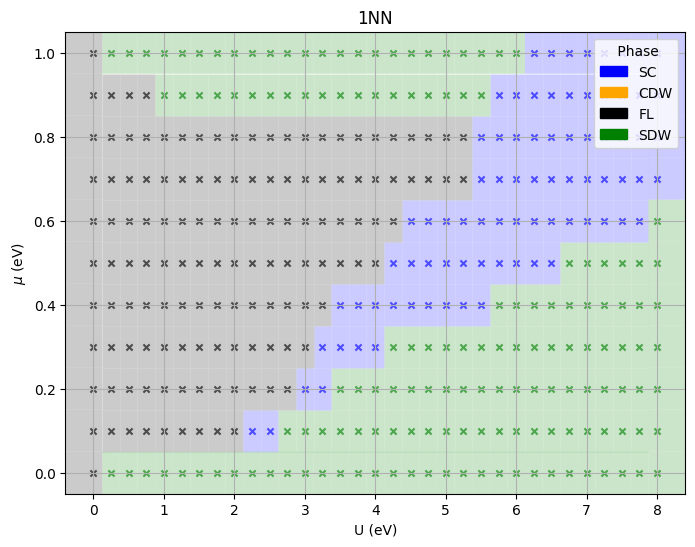

In [8]:
plot_U_J_Voronoi("1NNb.log","1NN")

In [5]:
def read_dataff(file_name):
    #This is specific to a file with no headings and in the form of:  k20_kf_5/2NN_0.00_0.0_20_5.out FL 9.01759e-06 1m43.863s
    f = open(file_name, 'r')
    data = []
    for line in f:
        l = line.split()

        if len(l) != 4:
            continue
        else:

            file= l[0].split("/")[-1].split("_") 
            U = float(file[1])  #stores U parameter
            J = float(file[2])  # stores J parameter 
            ff = float(file[3])
            nk = int(file[4])   #stores nk number points
            nkf = int(file[5].split(".")[0])   #stores nkf number points

            time= l[3].split("m")   #time taken to perform the calculation
            seconds = float(time[0])*60 + float(time[1].split("s")[0])
            final_data = [U, J, ff, nk, nkf,l[1],float(l[2]),seconds]  #l1 and l2 here are the Tc and the dominanting phase
            data.append(final_data)

    return data


In [21]:
def plot_ff_convergence(inputname, model):
    data = read_dataff(inputname)

    #kb_ev = 8.6173303e-5 #eV
    
    Us = []  #stores Us
    mus = []  #stores Js
    groundstate = []
    points = []
    tc = []
    ffs =[]
    times = []
    kb_ev = 1
    for d in data:
        Us.append(d[0])
        mus.append(d[1])
        points.append([d[0],d[1]])  #U,J vector
        groundstate.append(d[5])  #Stores GS
        ffs.append(d[2])
        tc.append((d[6])/kb_ev)  #stores Tc
        times.append(d[7])
    fig, ax = plt.subplots(figsize=(6, 6))
    ax.grid()

    fig, ax2 = plt.subplots(figsize=(16, 6))


    # Color mapping
    # Color mapping
    color_map = {
        "SC": "#A7C7E7",
        "CDW": "#FFB347",
        "FL": "black",
        "SDW": "#B0E57C"
    }


    labels_added = {}

    for i in range(len(ffs)):
        state = groundstate[i]
        colour = color_map.get(state, "white")

    # Add label only if it hasn't been added before
        label = state if state not in labels_added else None
        labels_added[state] = True  # Mark label as used

        ax.scatter(ffs[i], tc[i], c=colour, s=70, marker="o", label=label)
        ax2.scatter(ffs[i], times[i], c = colour, s =70, marker = "x", label= label)




   # for i in range(len(ffs)):
    
#    if groundstate[i] == "SC":
 #           colour = 'blue'
  #      elif groundstate[i] == "CDW":
   #         colour = 'orange'
    #    elif groundstate[i] == "FL":
     #       colour="black"
      #  elif groundstate[i] == "SDW":
       #     colour="green"
        #else:
         #   colour="white"
        #ax.scatter(ffs[i], tc[i], c=colour, s=20,marker="x")

    U = Us[0]
    mu = mus[0]

    #ax.set_title(f"Form factor convergence for the {model} with U = {U} and $\mu$ = {mu}")
    ax.set_xlabel("Form factor ($\AA$)", fontsize = 18)
    ax.set_ylabel("Tc (ev)", fontsize  =18 )
    ax.plot(ffs, tc, color = 'black', linestyle = '--')
    ax2.plot(ffs, times, color = 'black', linestyle = '--')
    ax2.set_title(f"Time taken as a function of Form factor for the {model} with U = {U} and $\mu$ = {mu}")
    ax2.set_xlabel("Form factor ($\AA$)")
    ax2.set_ylabel("Time (s)")
    ax2.legend()
    ax2.grid()
    ax.tick_params(axis="both", labelsize =18)
    
    ax.legend(fontsize = 18)
    plt.show()


AttributeError: 'Axes' object has no attribute 'tickparams'

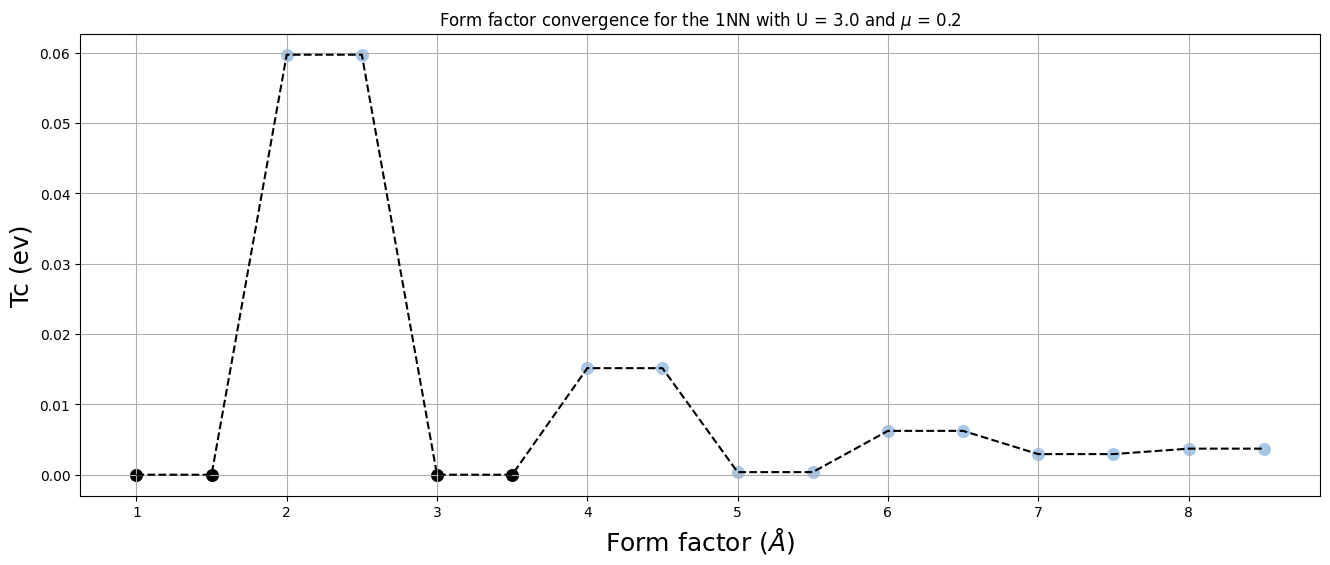

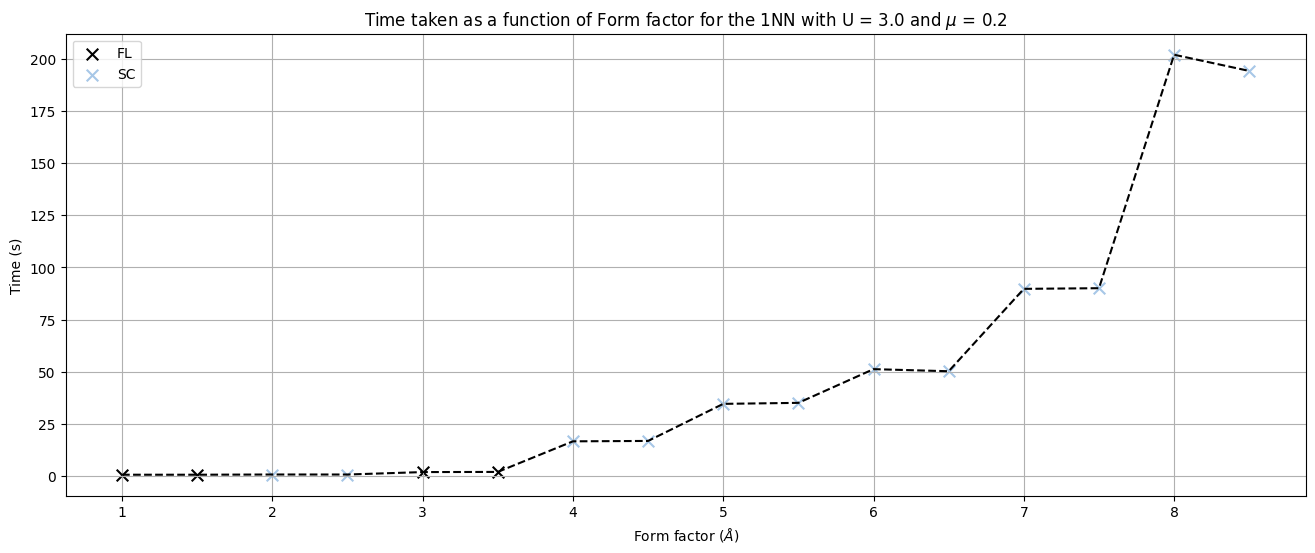

In [17]:
plot_ff_convergence("1NN_ff.log", "1NN")


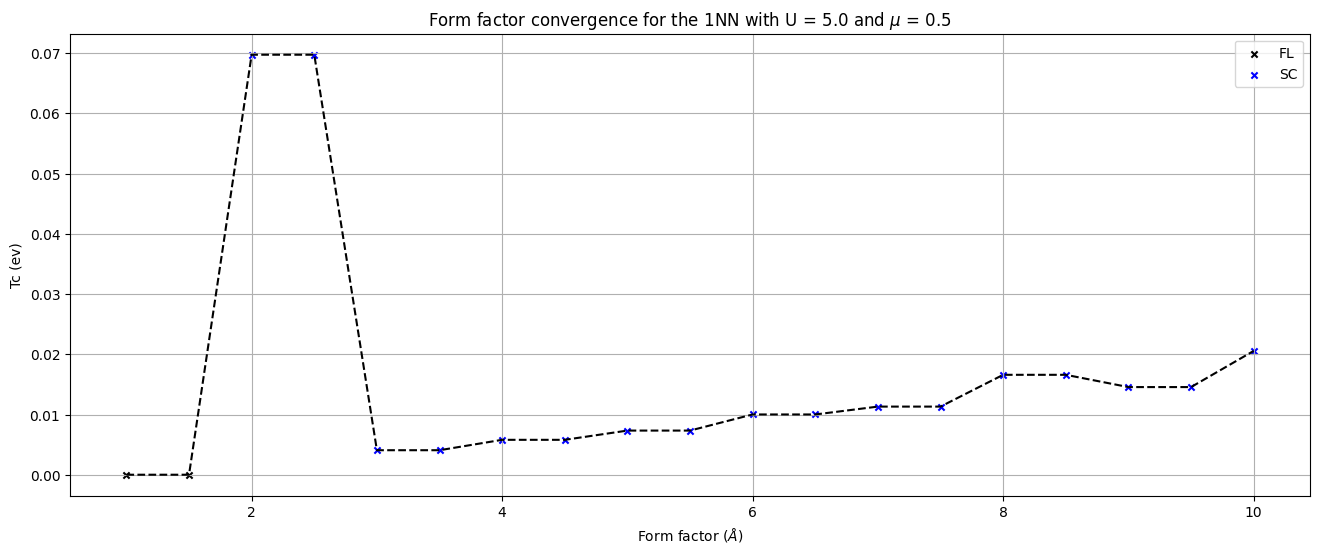

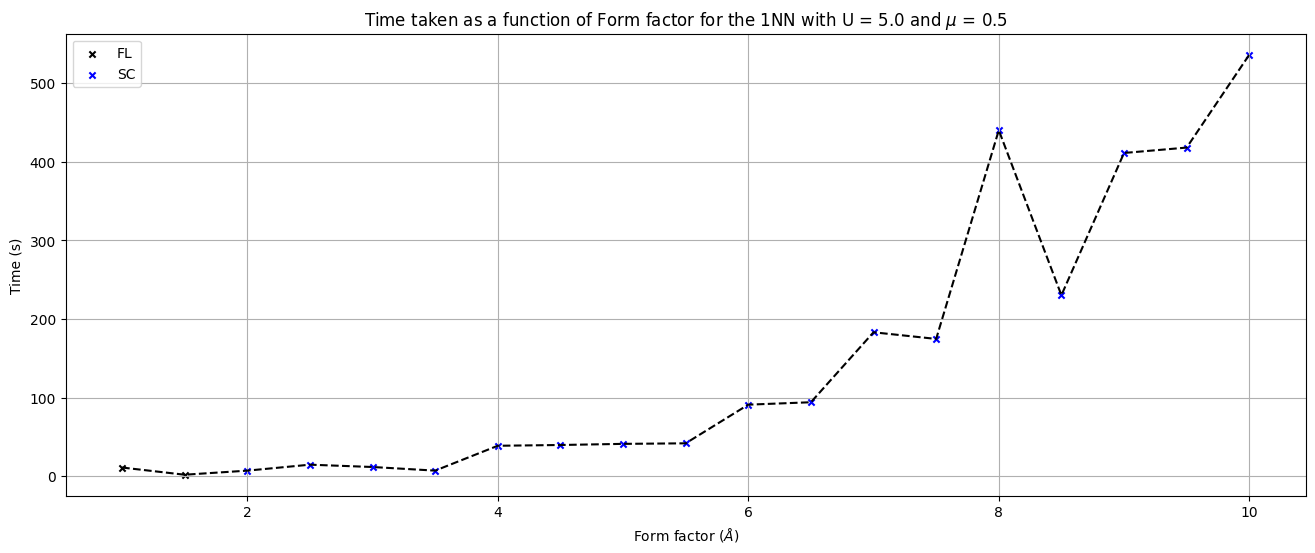

In [8]:
plot_ff_convergence("1NN_ff2.log", "1NN")

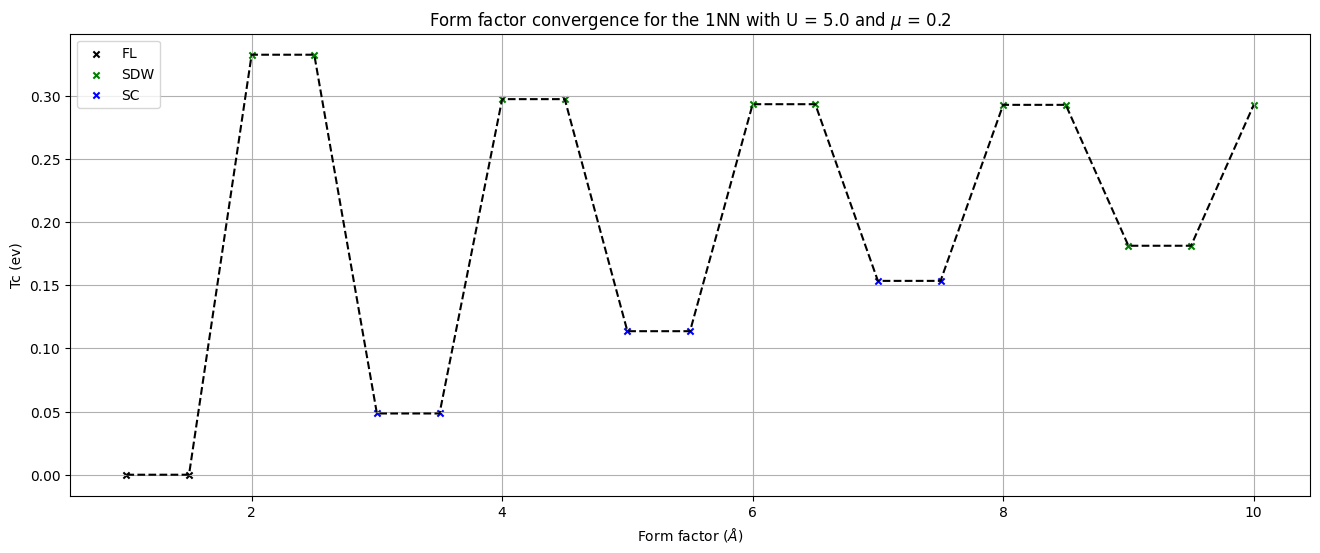

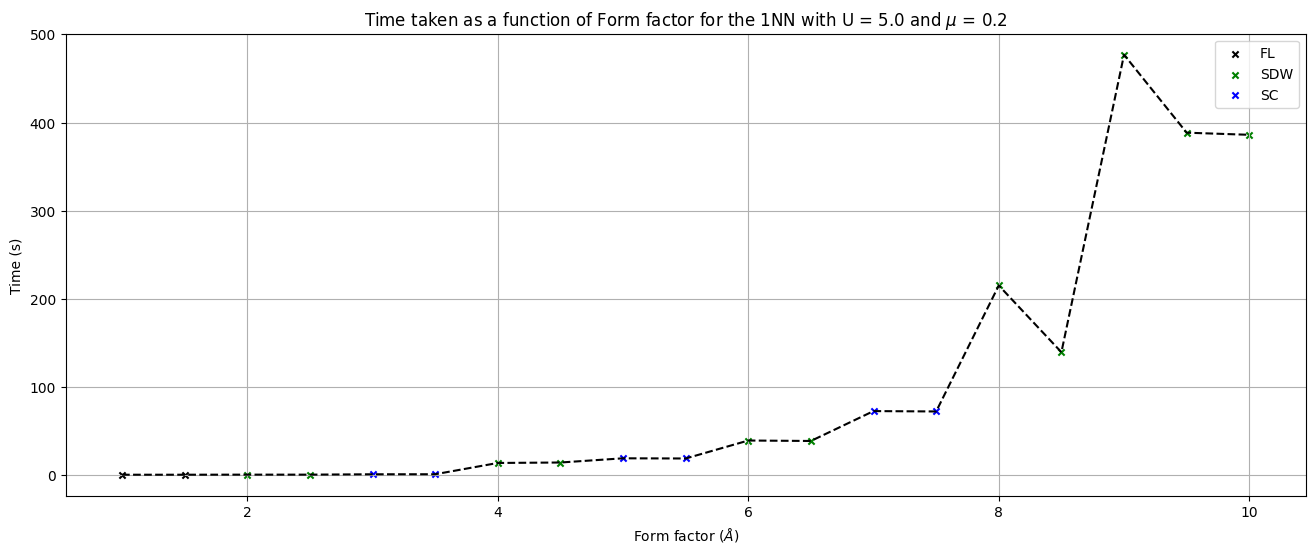

In [9]:

plot_ff_convergence("1NN_ff3.log", "1NN")

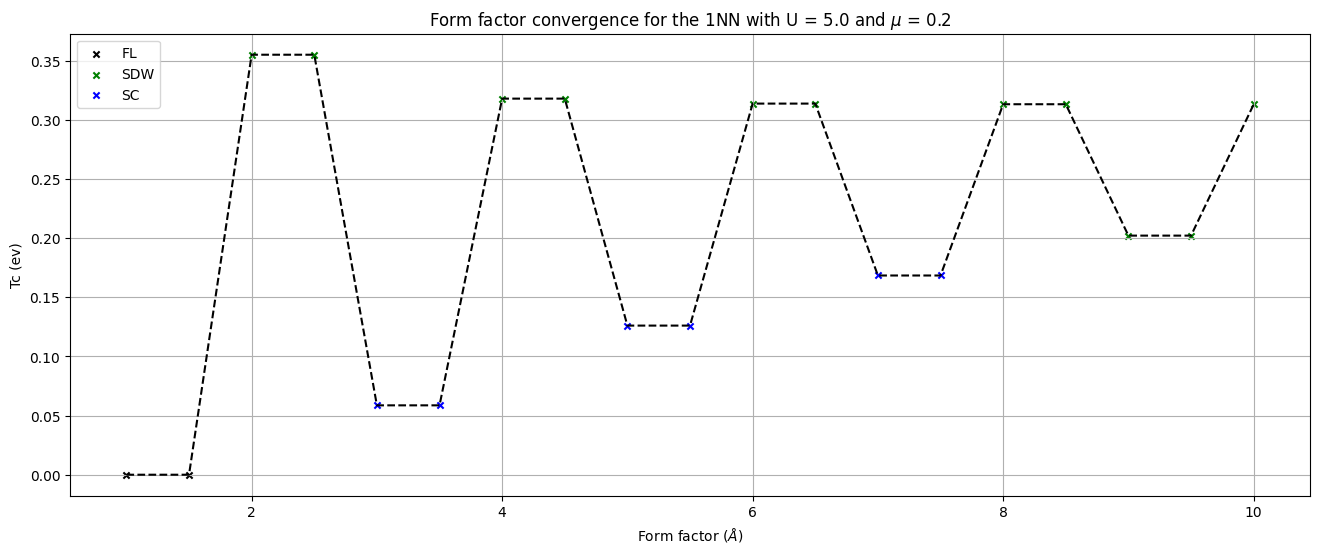

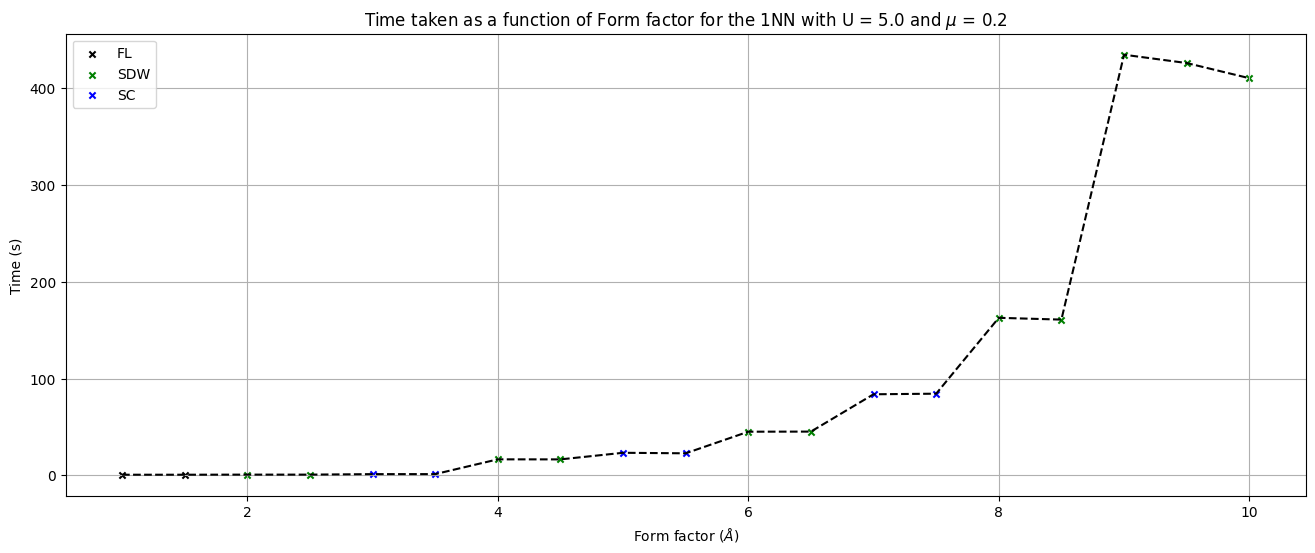

In [14]:
plot_ff_convergence("1NN_ff4.log", "1NN")

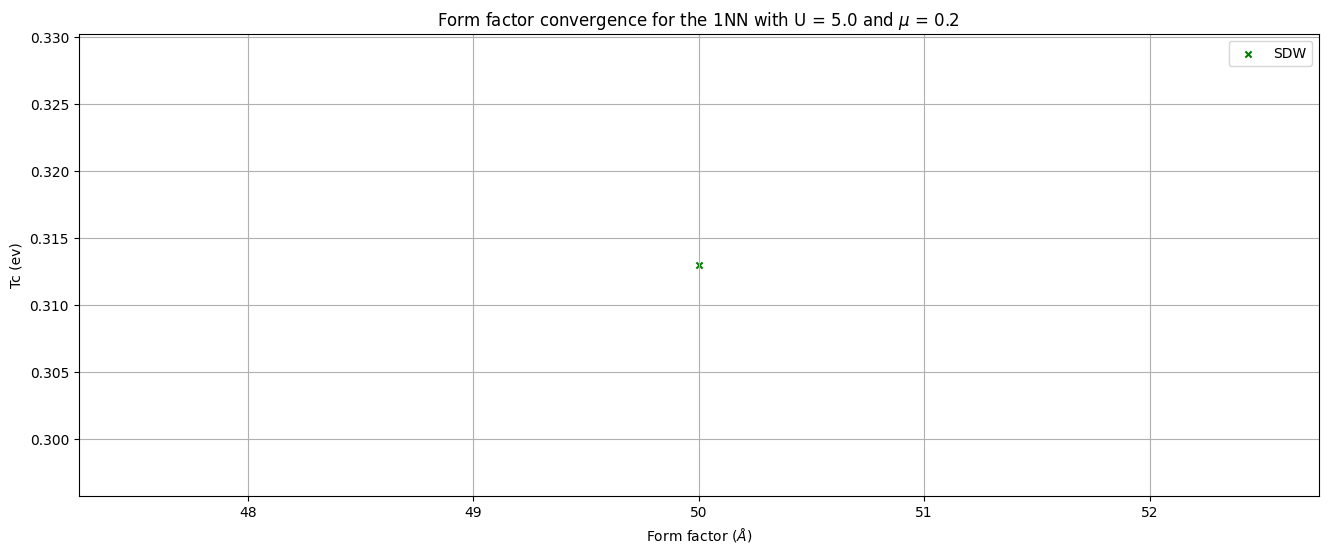

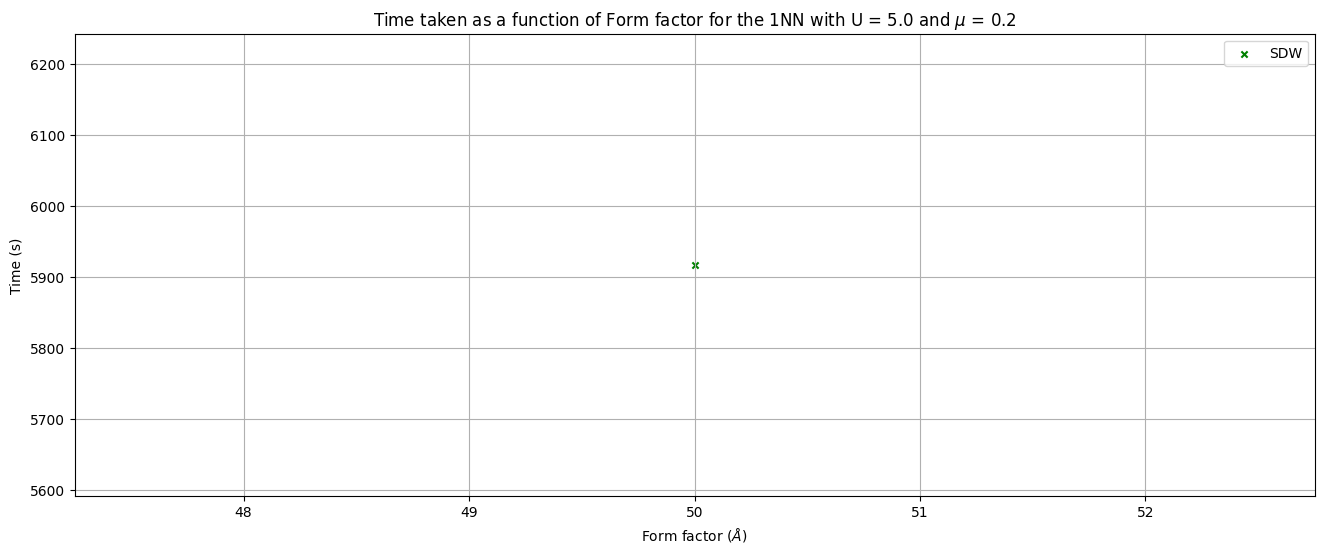

In [15]:
plot_ff_convergence("1NN_ff5.log", "1NN")

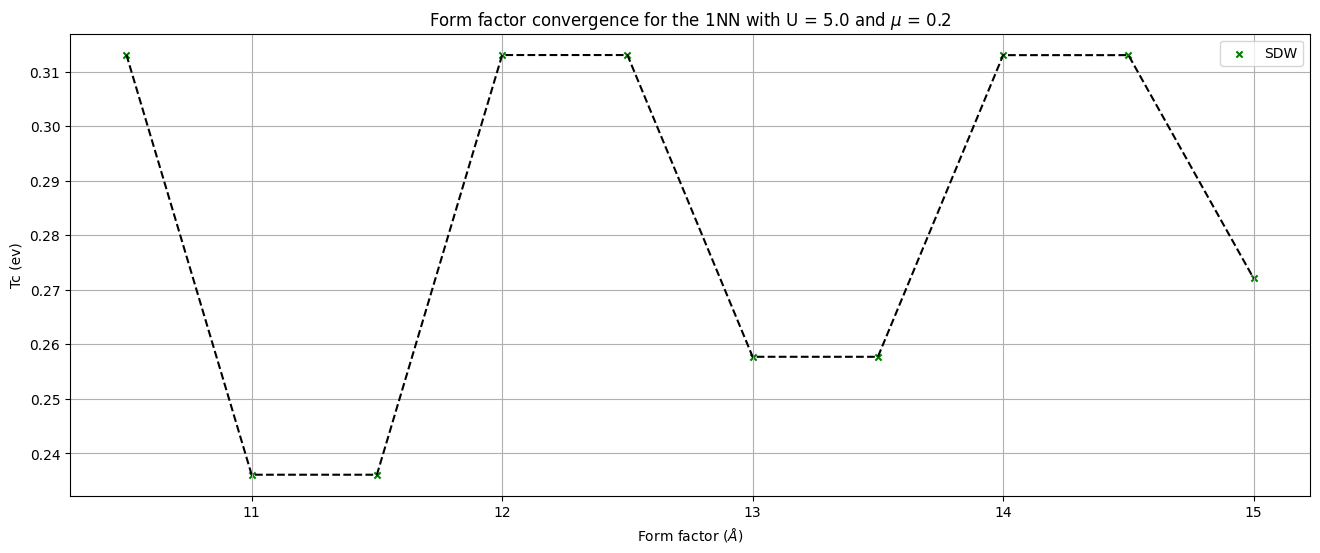

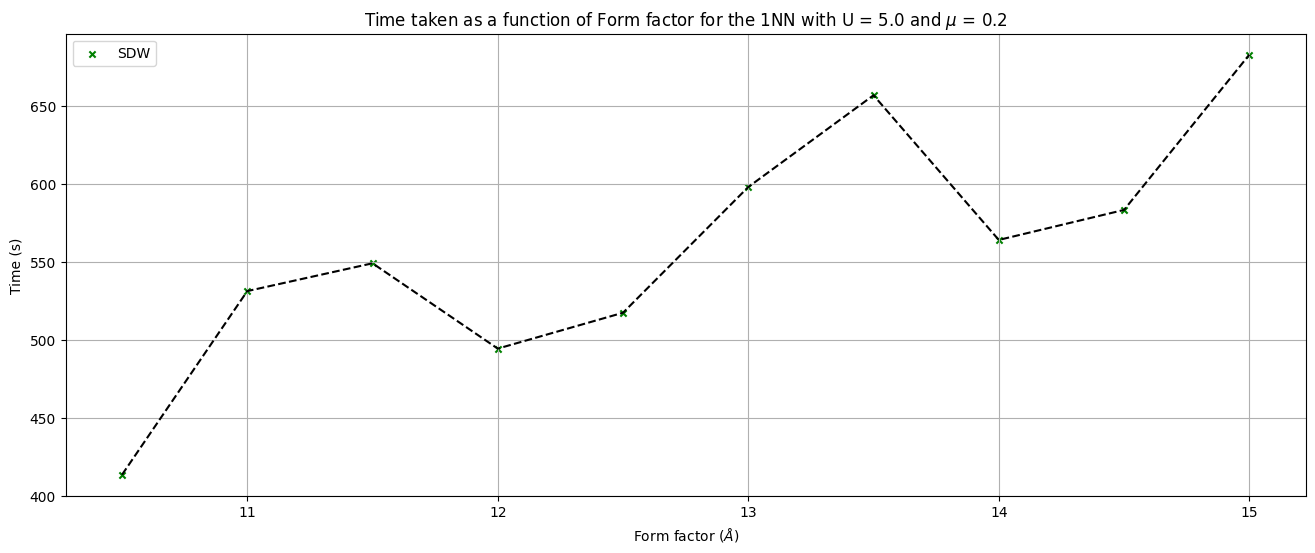

In [16]:
plot_ff_convergence("1NN_ff6.log", "1NN")

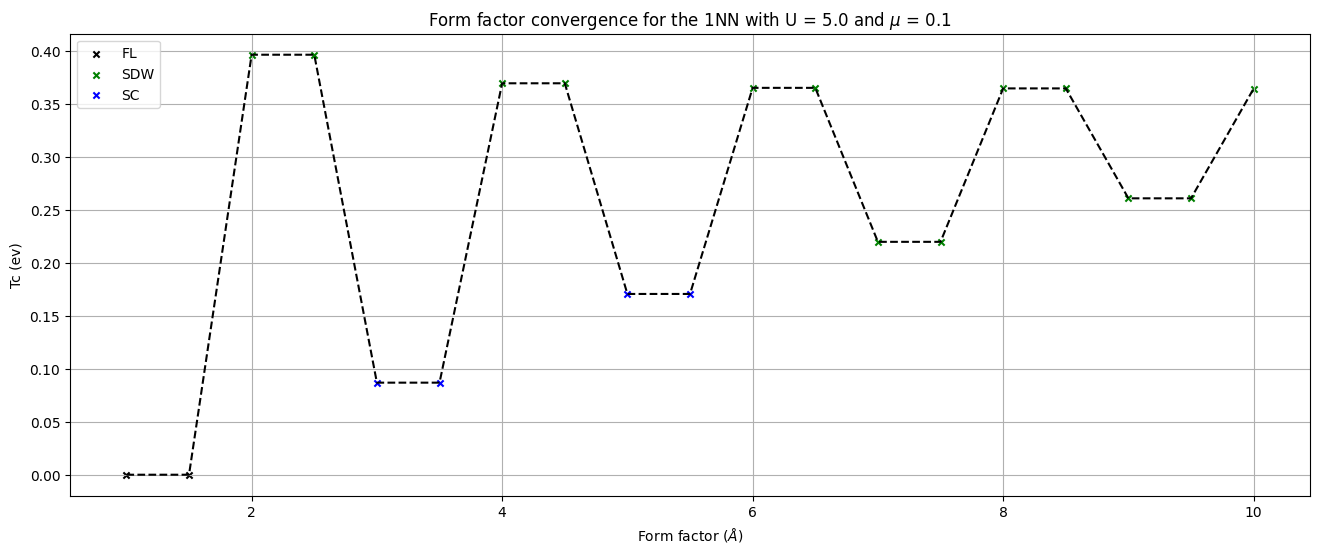

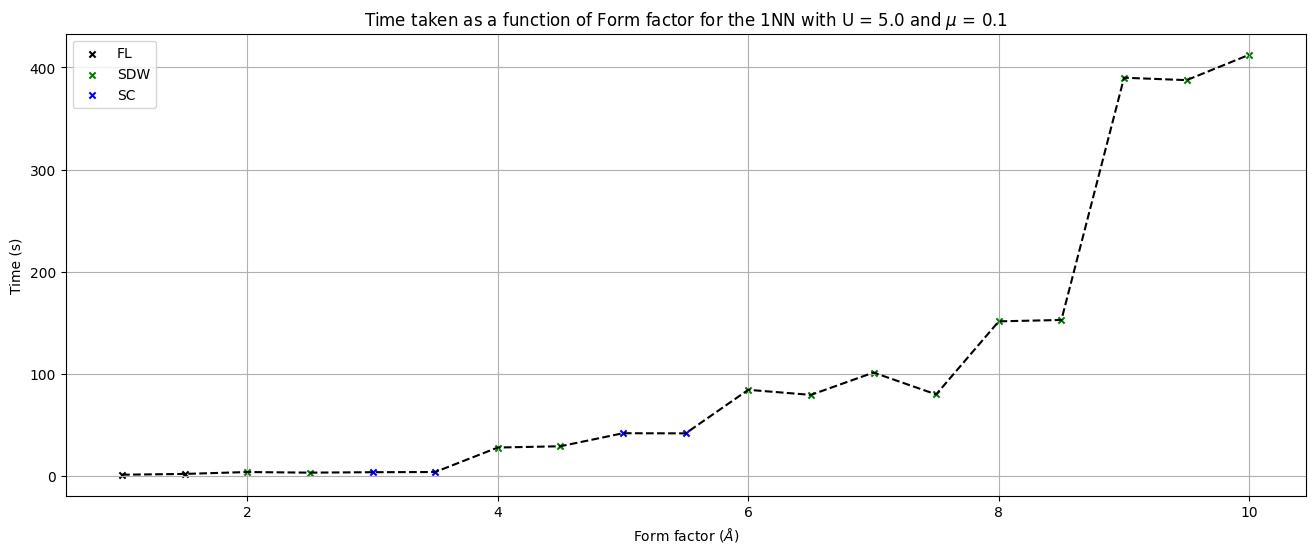

In [17]:
plot_ff_convergence("1NN_ff7.log", "1NN")


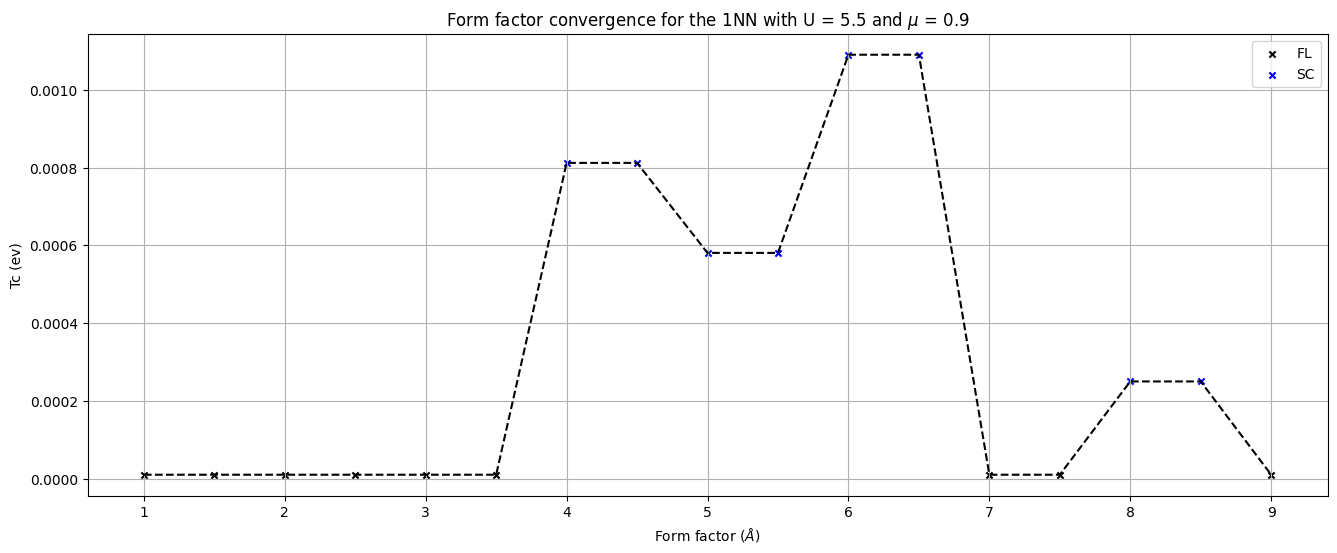

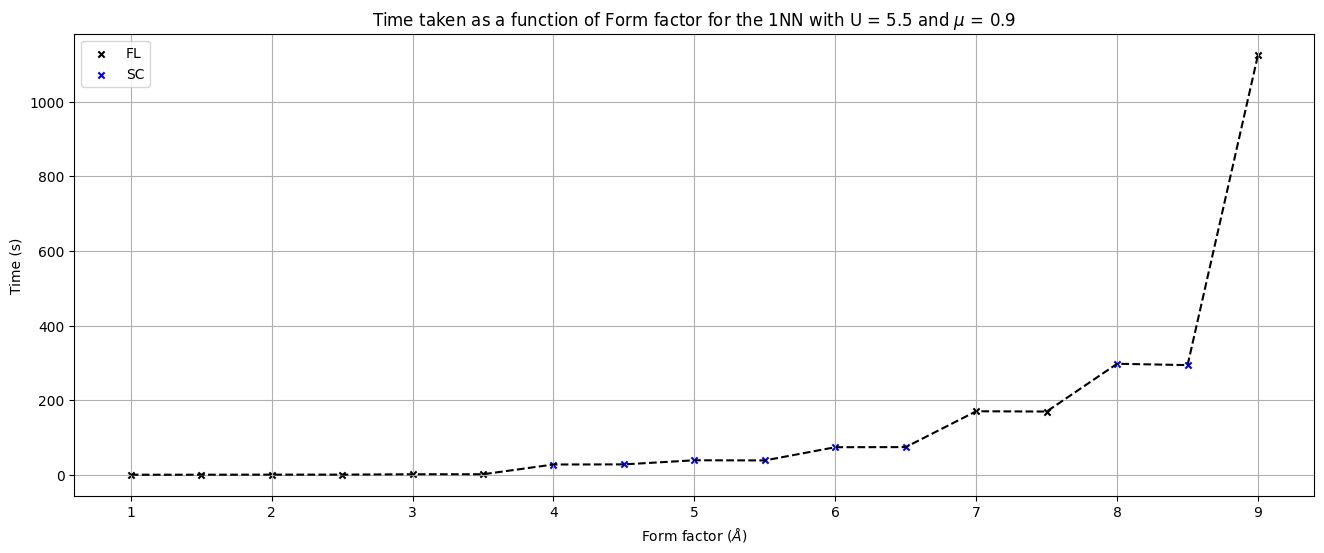

In [18]:
plot_ff_convergence("1NN_ff8.log", "1NN")

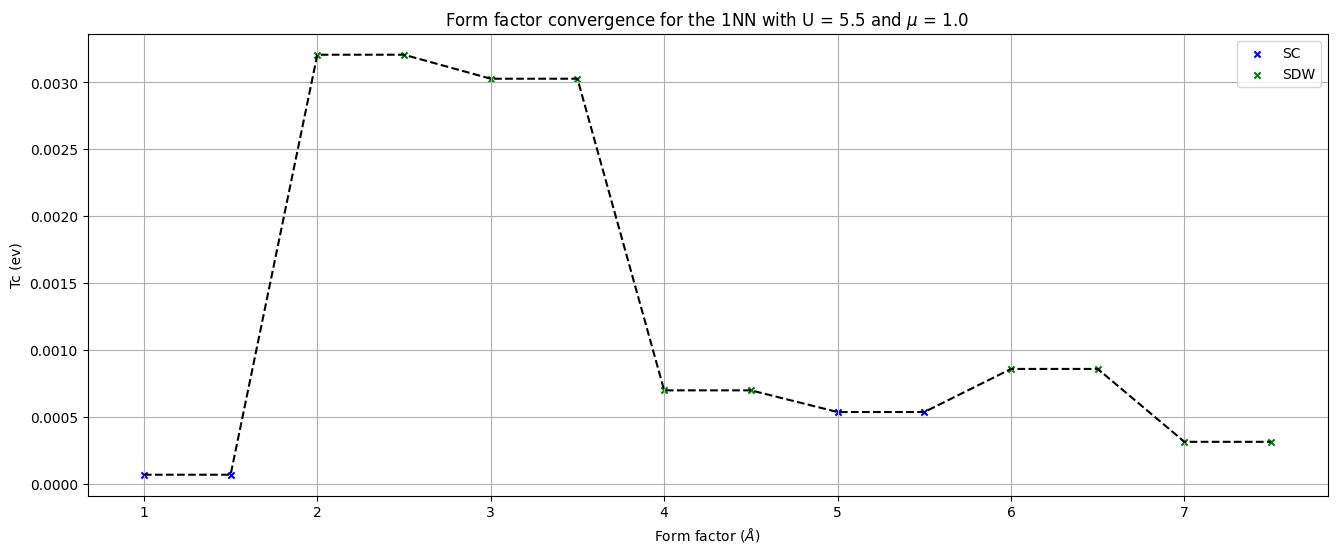

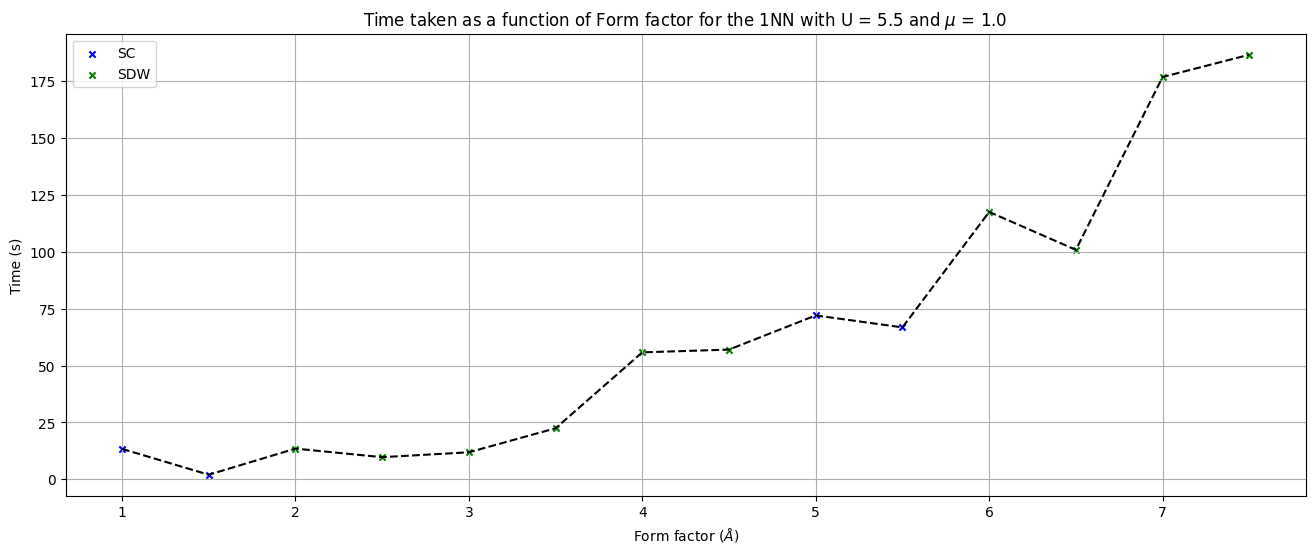

In [19]:
plot_ff_convergence("1NN_ff9.log", "1NN")

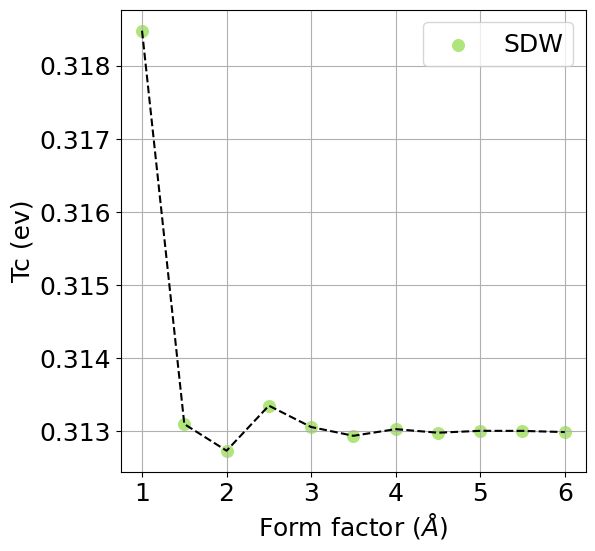

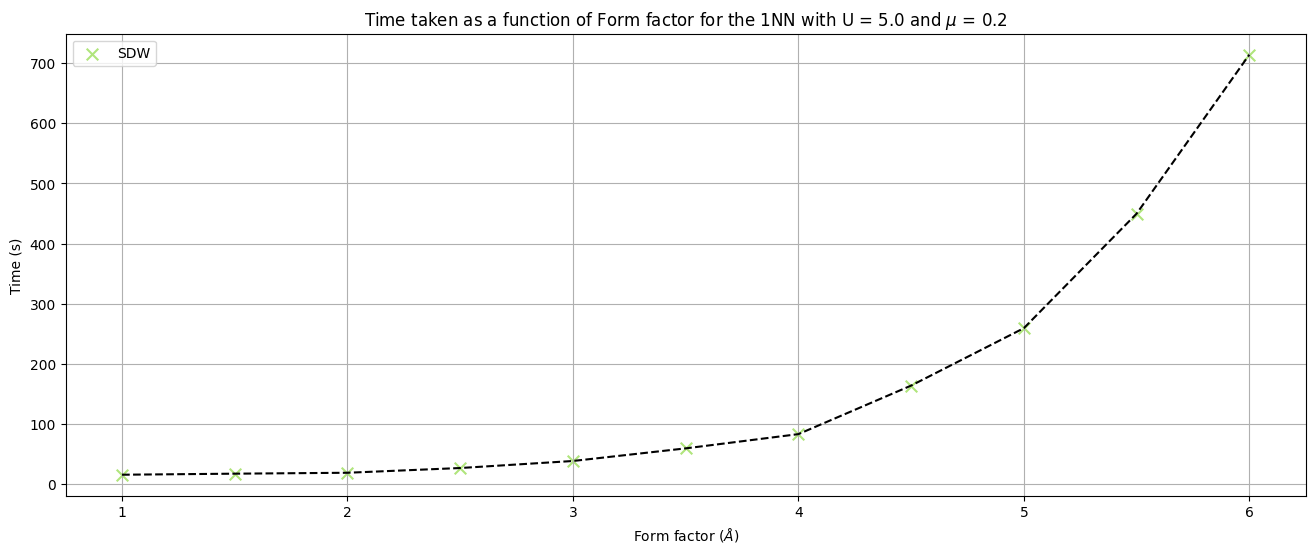

In [22]:
plot_ff_convergence("1NN_ff10.log", "1NN")

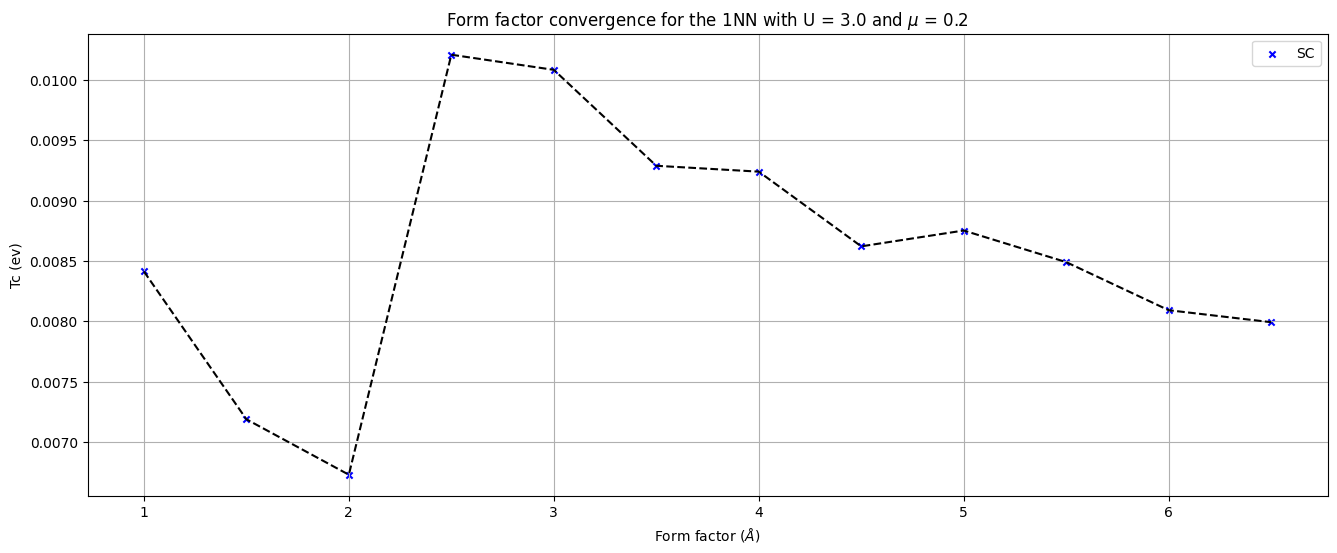

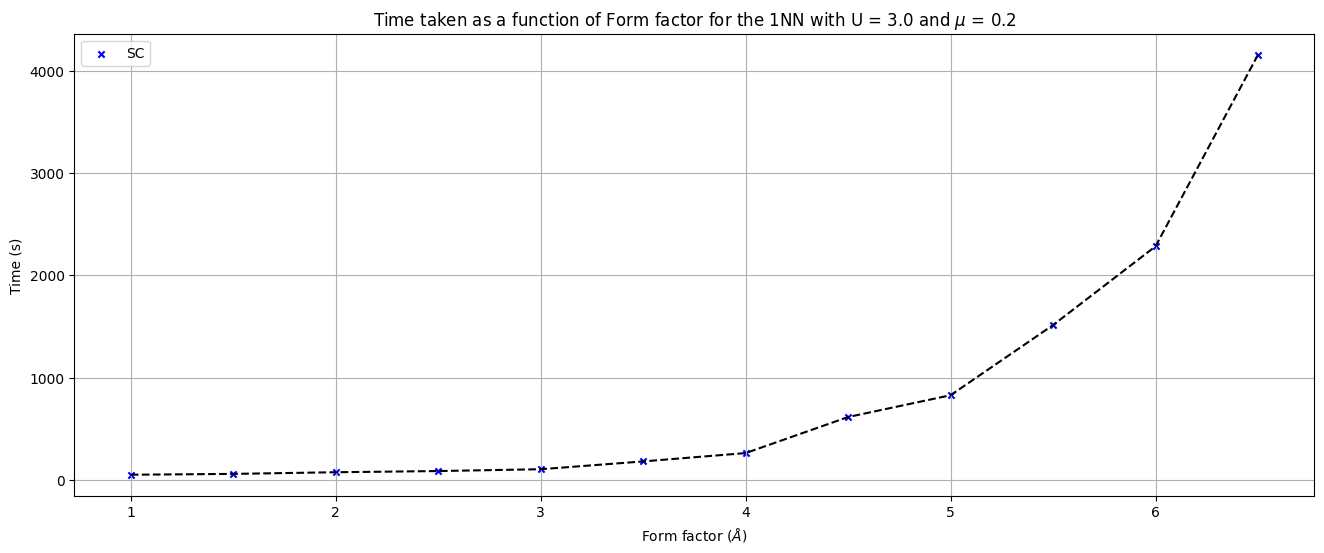

In [21]:
plot_ff_convergence("1NN_ff11.log", "1NN")

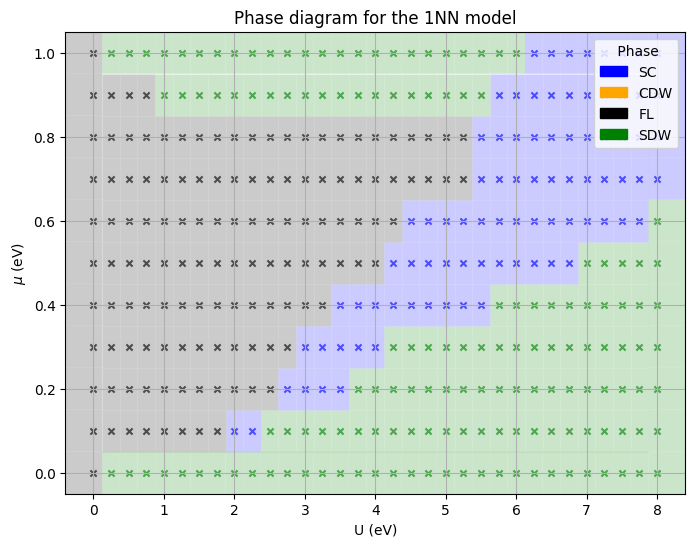

In [22]:
plot_U_J_Voronoi("1NN_pd.log","Phase diagram for the 1NN model")

In [23]:
def plot_Tc(data,mu):
    data = read_data(data)

    groundstate = []
    Us = []
    points = []
    tc = []
    nk =[]
    nkf = []
    times = []
    for d in data:
        if d[1] == mu:
            Us.append(d[0])
            #mu.append(d[1])
            points.append([d[2],d[3]])  #nk, nkf vector
            groundstate.append(d[4])  #Stores GS
            nk.append(d[2])
            nkf.append(d[3])
            tc.append(d[5])  #stores Tc
            times.append(d[6])

    df = pd.DataFrame({
        'U': Us,
        'mu':mu,
        'tc(eV)': tc,
        'groundstate': groundstate,
        'time (s)': times
     })
    
    fig, ax = plt.subplots(figsize=(16, 6))
    ax.grid()

    color_map = {
        "SC": "blue",
        "CDW": "orange",
        "FL": "black",
        "SDW": "green"
    }

    labels_added = {}

    for i in range(len(Us)):
        state = groundstate[i]
        colour = color_map.get(state, "white")

    # Add label only if it hasn't been added before
        label = state if state not in labels_added else None
        labels_added[state] = True  # Mark label as used
        ax.scatter(Us[i], tc[i], c=colour, s=70, marker="x", label=label)

    ax.set_xlabel("U(eV)")
    ax.set_ylabel("Tc(eV)")
    ax.set_title(f"1NN model: Tc as a function of U for $\mu$= {mu}")
    return df

U   mu    tc(eV) groundstate  time (s)
0   0.00  0.2  0.000010          FL   183.930
1   0.25  0.2  0.000010          FL   184.005
2   0.50  0.2  0.000010          FL   183.654
3   0.75  0.2  0.000010          FL   183.246
4   1.00  0.2  0.000010          FL   182.649
5   1.25  0.2  0.000010          FL   184.778
6   1.50  0.2  0.000010          FL   184.040
7   1.75  0.2  0.000010          FL   183.276
8   2.00  0.2  0.000010          FL   184.357
9   2.25  0.2  0.000010          FL   184.218
10  2.50  0.2  0.000010          FL   183.571
11  2.75  0.2  0.001020          SC   139.886
12  3.00  0.2  0.009240          SC   125.516
13  3.25  0.2  0.024061          SC   130.866
14  3.50  0.2  0.047361          SC   144.915
15  3.75  0.2  0.089195         SDW   130.835
16  4.00  0.2  0.153309         SDW   103.140
17  4.25  0.2  0.199404         SDW    93.331
18  4.50  0.2  0.240020         SDW    87.630
19  4.75  0.2  0.275960         SDW    85.880
20  5.00  0.2  0.313032         SDW    83.027
21  5.25  0.2  0.346448         SDW    82.478
22  5.50  0.2  0.381805         SDW    80.205
23  5.75  0.2  0.415077         SDW    79.060
24  6.00  0.2  0.448373         SDW    78.409
25  6.25  0.2  0.478943         SDW    77.464
26  6.50  0.2  0.512134         SDW    76.947
27  6.75  0.2  0.545674         SDW    76.205
28  7.00  0.2  0.576155         SDW    75.966
29  7.25  0.2  0.609941         SDW    74.650
30  7.50  0.2  0.640051         SDW    74.855
31  7.75  0.2  0.670539         SDW    74.776
32  8.00  0.2  0.704761         SDW    73.875

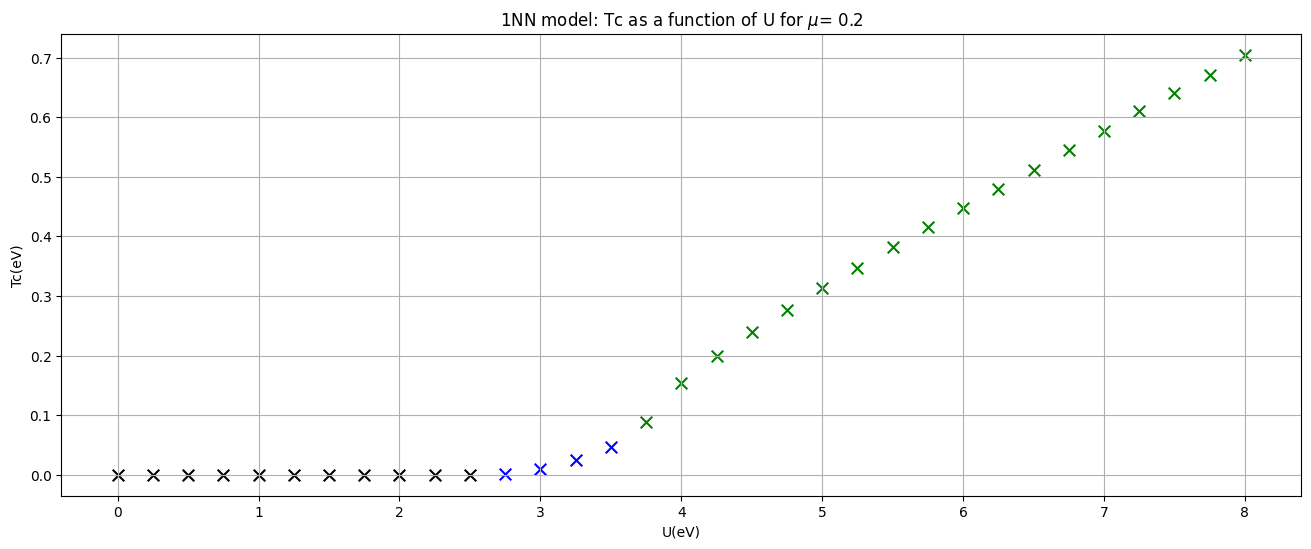

In [24]:
plot_Tc("1NN_pd.log", 0.2)

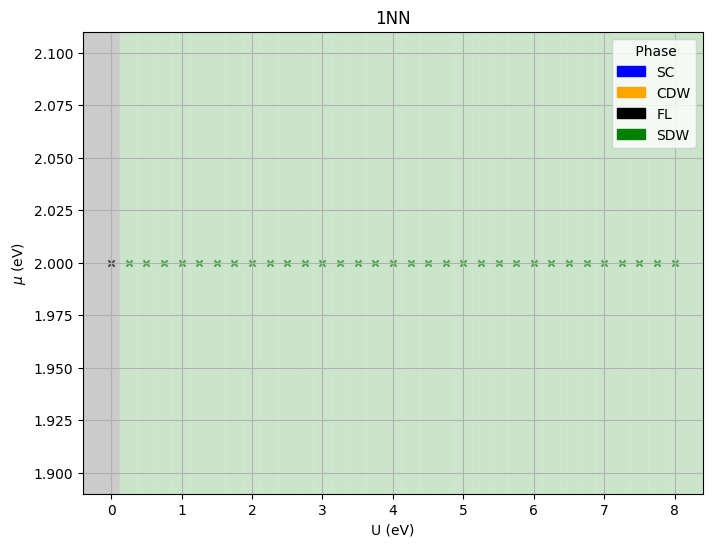

In [25]:
plot_U_J_Voronoi("1NN_mu2.log","1NN")

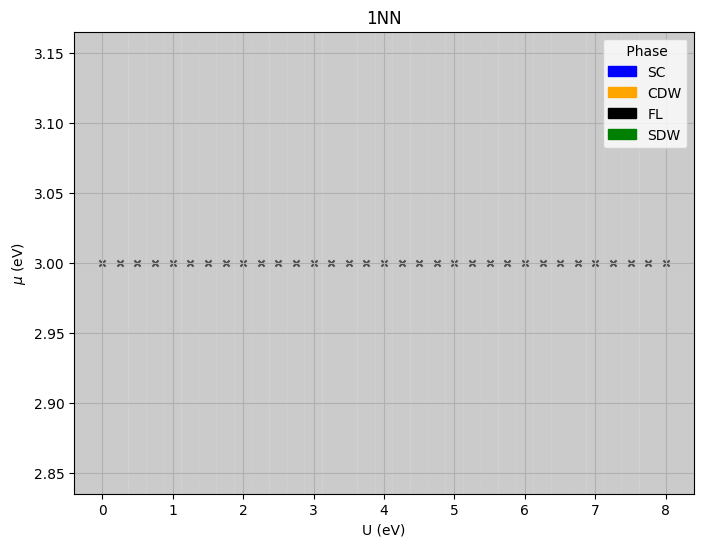

In [26]:
plot_U_J_Voronoi("1NN_mu3.log","1NN")

In [27]:
def read_data(file_name):
    """Reads and processes data from a given file, correctly handling filenames with 'ffX'."""
    data = []
    
    with open(file_name, 'r') as f:
        for line in f:
            l = line.split()
            
            if len(l) != 4:
                continue  # Skip lines that do not match expected format
            
            try:
                # Extract the filename and split into parts
                file_parts = l[0].split("/")[-1].split("_")

                # Remove any "ffX" component
                file_parts = [part for part in file_parts if not (part.startswith("ff") and part[2:].isdigit())]

                # Extract only the LAST 4 elements (since the earlier ones are not needed)
                U = float(file_parts[-4])   # Extracts U parameter
                J = float(file_parts[-3])   # Extracts J parameter
                nk = int(file_parts[-2])    # Extracts nk number points
                nkf = int(file_parts[-1].split(".")[0])  # Extracts nkf number points

                Tc = l[1]  # Tc value
                phase = float(l[2])  # Dominant phase
                
                # Extract time in seconds
                time_parts = l[3].split("m")
                seconds = float(time_parts[0]) * 60 + float(time_parts[1].split("s")[0])
                
                # Store data as a dictionary
                final_data = {
                    "U": U,
                    "J": J,
                    "nk": nk,
                    "nkf": nkf,
                    "Tc": Tc,
                    "phase": phase,
                    "time_seconds": seconds
                }
                
                data.append(final_data)
            
            except (ValueError, IndexError) as e:
                print(f"Skipping line due to error: {line.strip()} - {e}")
    
    return data


In [28]:
def read_data(file_name):
    """Reads and processes data from a given file, correctly handling filenames with 'ffX'."""
    data = []
    
    with open(file_name, 'r') as f:
        for line in f:
            l = line.split()
            
            if len(l) != 4:
                continue  # Skip lines that do not match expected format
            
            try:
                # Extract the filename and split into parts
                file_parts = l[0].split("/")[-1].split("_")

                # Remove any "ffX" component
                file_parts = [part for part in file_parts if not (part.startswith("ff") and part[2:].isdigit())]

                # Extract only the LAST 4 elements (since the earlier ones are not needed)
                U = float(file_parts[-4])   # Extracts U parameter
                J = float(file_parts[-3])   # Extracts J parameter
                nk = int(file_parts[-2])    # Extracts nk number points
                nkf = int(file_parts[-1].split(".")[0])  # Extracts nkf number points

                Tc = l[1]  # Tc value
                phase = float(l[2])  # Dominant phase
                
                # Extract time in seconds
                time_parts = l[3].split("m")
                seconds = float(time_parts[0]) * 60 + float(time_parts[1].split("s")[0])
                
                # Store data as a LIST (not dictionary)
                final_data = [U, J, nk, nkf, Tc, phase, seconds]
                data.append(final_data)
            
            except (ValueError, IndexError) as e:
                print(f"Skipping line due to error: {line.strip()} - {e}")
    
    return data


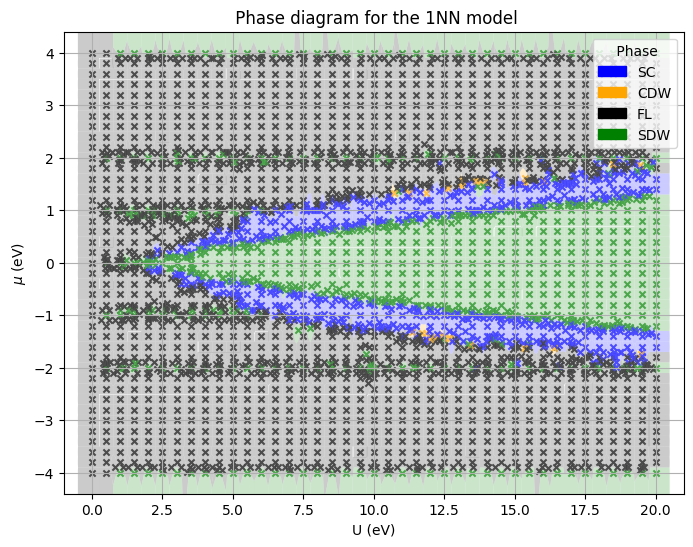

In [29]:
plot_U_J_Voronoi("1NN_20_5_ff4_PhaseDiagram.log"," Phase diagram for the 1NN model")

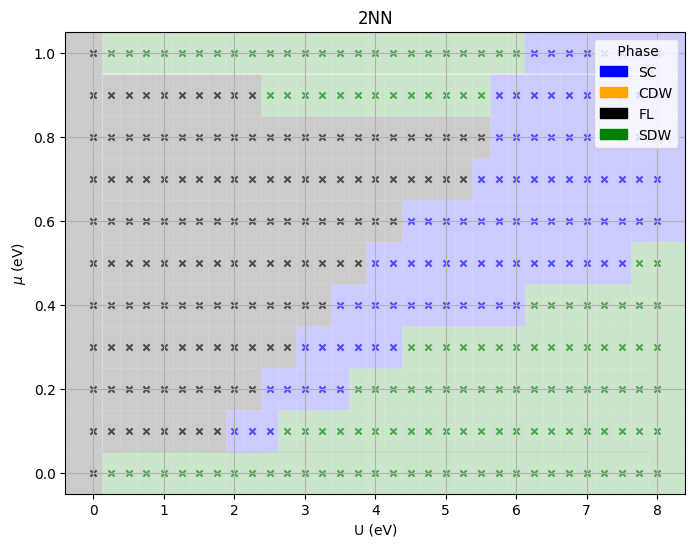

In [30]:
plot_U_J_Voronoi("2NNpd2.log","2NN")

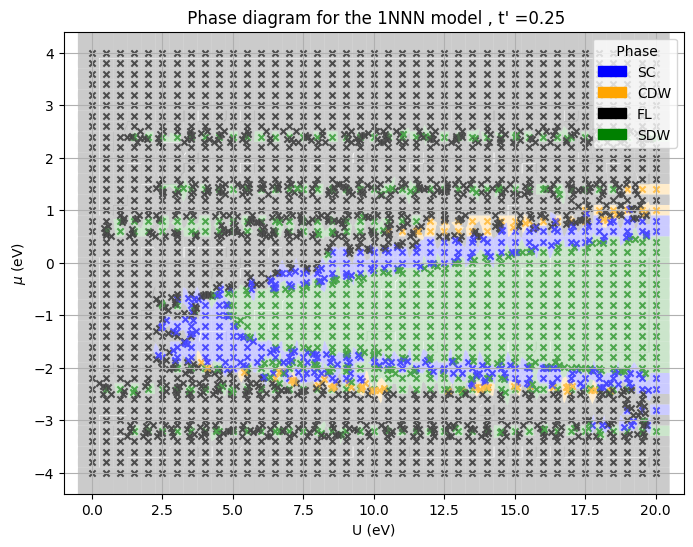

In [31]:
plot_U_J_Voronoi("1NNN_0p25_20_5_ff4_PhaseDiagram.log"," Phase diagram for the 1NNN model , t' =0.25")

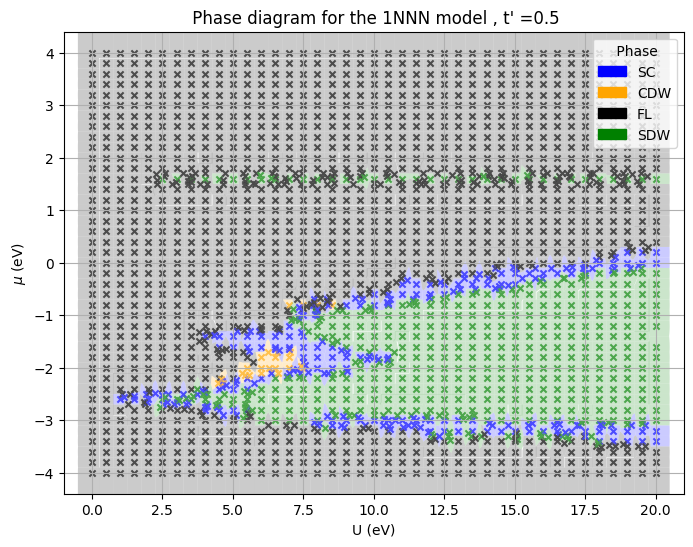

In [32]:
plot_U_J_Voronoi("1NNN_0p5_20_5_ff4_PhaseDiagram.log"," Phase diagram for the 1NNN model , t' =0.5")

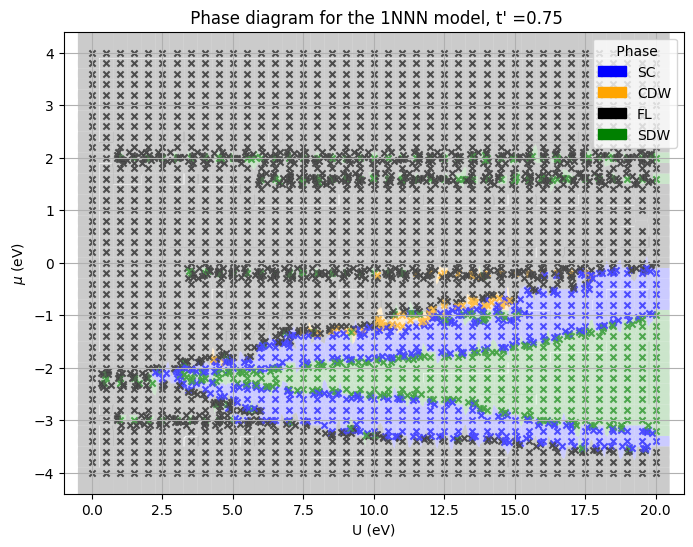

In [33]:
plot_U_J_Voronoi("1NNN_0p75_20_5_ff4_PhaseDiagram.log"," Phase diagram for the 1NNN model, t' =0.75")

In [34]:
def plot_Tc(data, U):

    #specify U for which th Tc is plotted 
    data = read_data(data)

    groundstate = []
    Us = []
    mu = []
    points = []
    tc = []
    nk =[]
    nkf = []
    times = []
    for d in data:
        if d[0] == U:

            Us.append(d[0])
            mu.append(d[1])
            points.append([d[2],d[3]])  #nk, nkf vector
            groundstate.append(d[4])  #Stores GS
            nk.append(d[2])
            nkf.append(d[3])
            tc.append(d[5])  #stores Tc
            times.append(d[6])
    
    fig, ax = plt.subplots(figsize=(8, 6))
    ax.grid()

    color_map = {
        "SC": "#A7C7E7",
        "CDW": "#FFB347",
        "FL": "black",
        "SDW": "#B0E57C"
    }

    labels_added = {}

    for i in range(len(Us)):
        state = groundstate[i]
        colour = color_map.get(state, "white")

    # Add label only if it hasn't been added before
        label = state if state not in labels_added else None
        labels_added[state] = True  # Mark label as used
        ax.scatter(mu[i], tc[i], c=colour, s=120, marker="o", label=label)
    
    ax.plot(mu, tc, ls ='--', color = 'grey')
   # ax.axvline(-3.85, ls ='--', color = 'black')
    #ax.axvline(-2.15, ls ='--', color = 'black')
    #ax.axvline(-1.85, ls ='--', color = 'black')
    #ax.axvline(3.85, ls ='--', color = 'black')
    #ax.axvline(2.15, ls ='--', color = 'black')
    #ax.axvline(1.85, ls ='--', color = 'black')
    #ax.axvline(-1.35, ls ='--', color = 'black')
    #ax.axvline(1.35, ls ='--', color = 'black')
    #ax.axvline(-0.65, ls ='--', color = 'black')
    #ax.axvline(0.65, ls ='--', color = 'black')
    ax.tick_params('both', labelsize = 20)
    ax.legend(fontsize =20)
    ax.set_xlabel(r"$\mu$(eV)", fontsize = 20)
    ax.set_ylabel("Tc(eV)", fontsize =20)

    #ax.set_title(f"1NN model: Tc as a function of doping ($\mu$) for U= {U}")

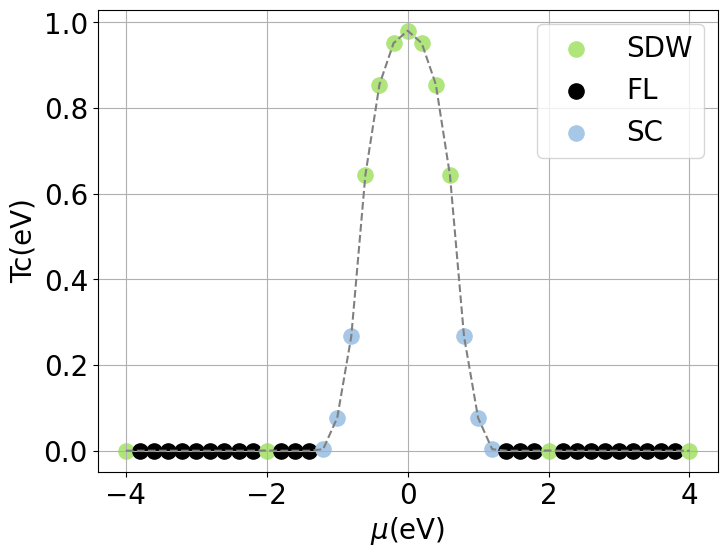

In [35]:
plot_Tc("1NN_20_5_ff4_PhaseDiagram.log", 10)
plt.savefig("1NNTcformu.png")

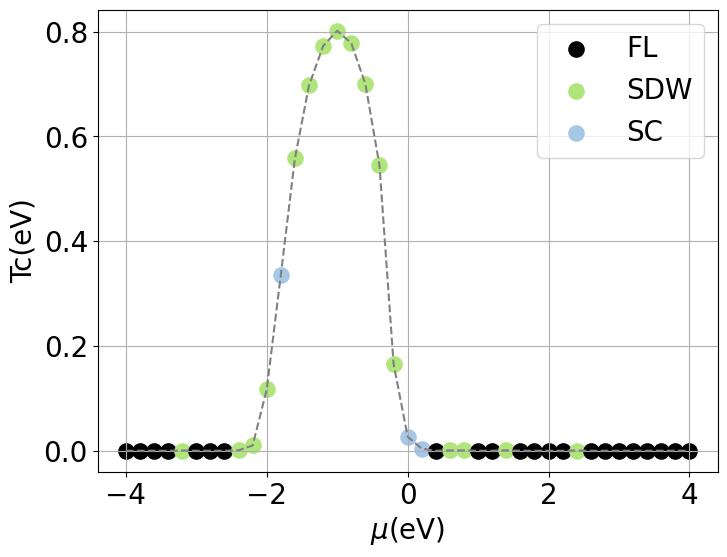

In [36]:
plot_Tc("1NNN_0p25_20_5_ff4_PhaseDiagram.log", 10)
plt.savefig("1NNN0p25Tcformu.png")

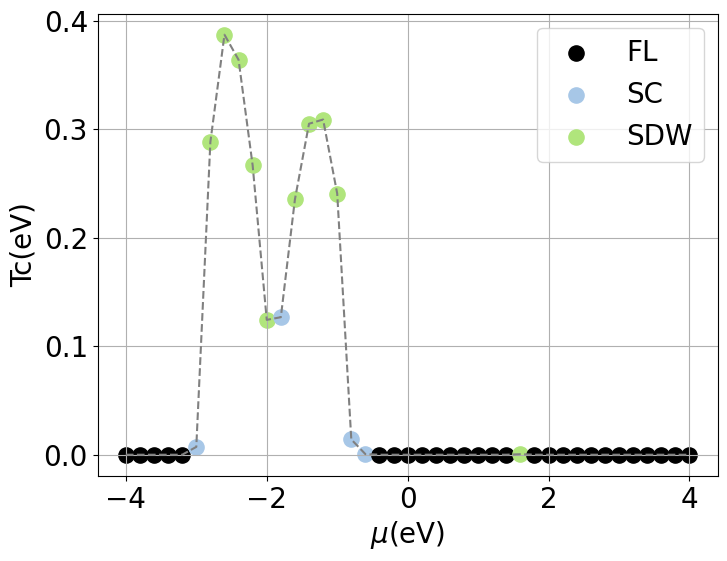

In [43]:
plot_Tc("1NNN_0p5_20_5_ff4_PhaseDiagram.log", 10)
plt.savefig("1NNN0p75Tcformu.png")

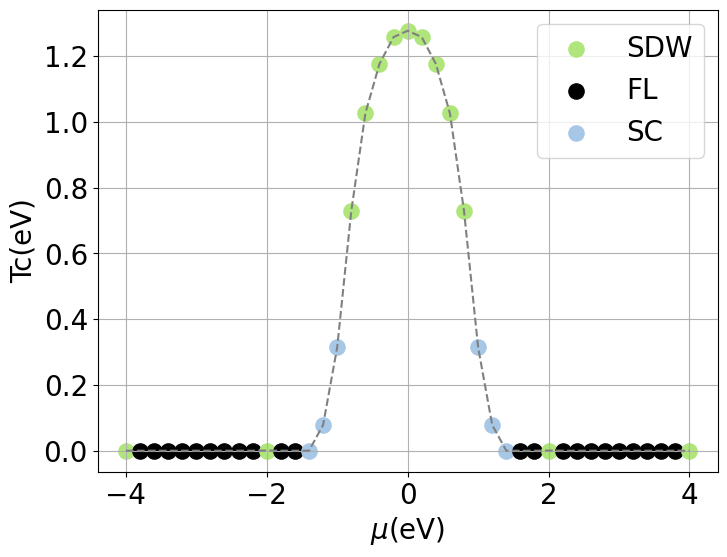

In [38]:
plot_Tc("1NN_20_5_ff4_PhaseDiagram.log", 12.5)

In [39]:
def plot_Tc_mu(data, mus):

    #specify U for which th Tc is plotted 
    data = read_data(data)

    groundstate = []
    Us = []
    mu = []
    points = []
    tc = []
    nk =[]
    nkf = []
    times = []
    for d in data: 
        if d[1] == mus:
            

            Us.append(d[0])
            mu.append(d[1])
            points.append([d[2],d[3]])  #nk, nkf vector
            groundstate.append(d[4])  #Stores GS
            nk.append(d[2])
            nkf.append(d[3])
            tc.append(d[5])  #stores Tcplot_Tc("1NNN_0p75_20_5_ff4_PhaseDiagram.log", 3)
            times.append(d[6])
    
    fig, ax = plt.subplots(figsize=(16, 6))
    ax.grid()

   
    color_map = {
        "SC": "#A7C7E7",
        "CDW": "#FFB347",
        "FL": "black",
        "SDW": "#B0E57C"
    }

    labels_added = {}

    for i in range(len(Us)):
        state = groundstate[i]
        colour = color_map.get(state, "white")

    # Add label only if it hasn't been added before
        label = state if state not in labels_added else None
        labels_added[state] = True  # Mark label as used
        ax.scatter(Us[i], tc[i], c=colour, s=100, marker="o", label=label)
    Us = np.sort(Us)
    tc = np.sort(tc)
        
    ax.plot(Us, tc, color = "grey", ls='--' )
    ax.axvline(6.25, ls ='--', color = "black")
    ax.axvline(14.25, ls ='--', color = "black")
    ax.axvline(0.25, ls ='--', color = "black")
        
    ax.legend(fontsize =20)
    ax.set_xlabel("U(eV)", fontsize =30)
    ax.set_ylabel("Tc(eV)", fontsize =30)
    ax.tick_params(axis='x', labelsize=20)
    ax.tick_params(axis='y', labelsize=20)
    #ax.set_title(f"Tc as a function of Coloumb repulsion U for  $\mu$ = {mus}", fontsize = 16)

In [40]:
plot_Tc_

NameError: name 'plot_Tc_' is not defined

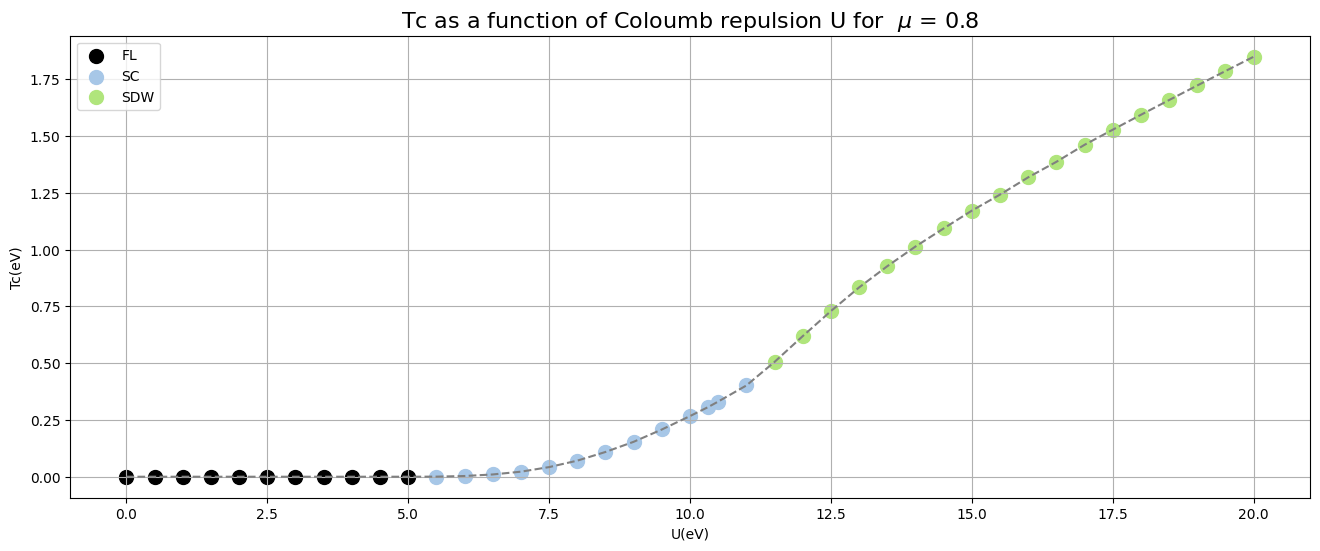

In [38]:
plot_Tc_mu("1NN_20_5_ff4_PhaseDiagram.log", 0.8)

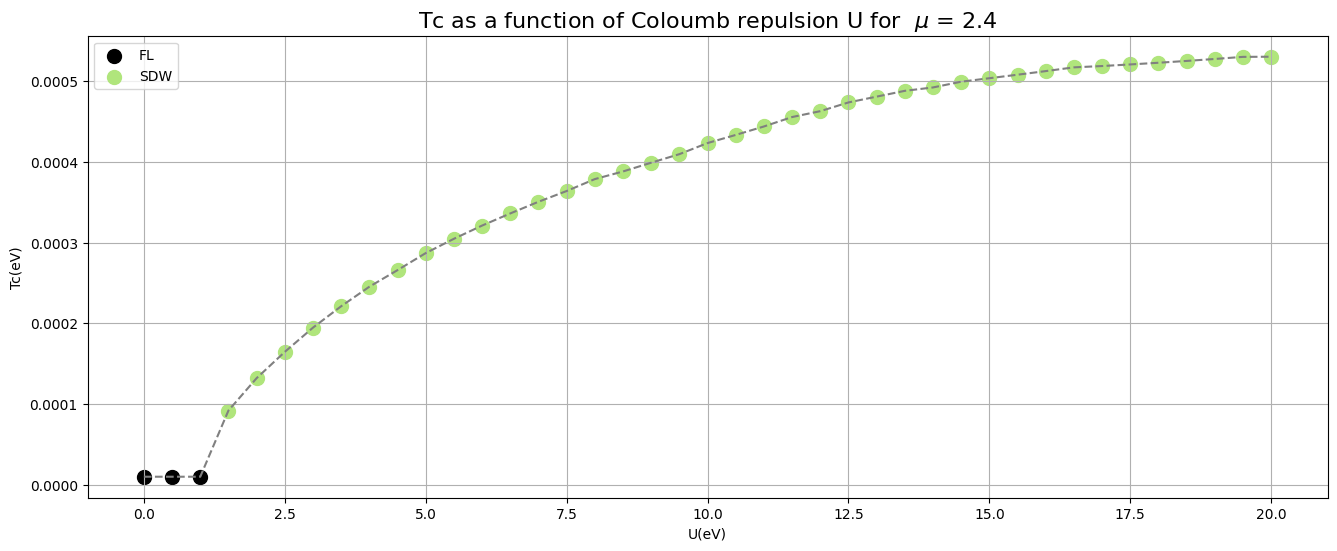

In [39]:
plot_Tc_mu("1NNN_0p25_20_5_ff4_PhaseDiagram.log", 2.4)

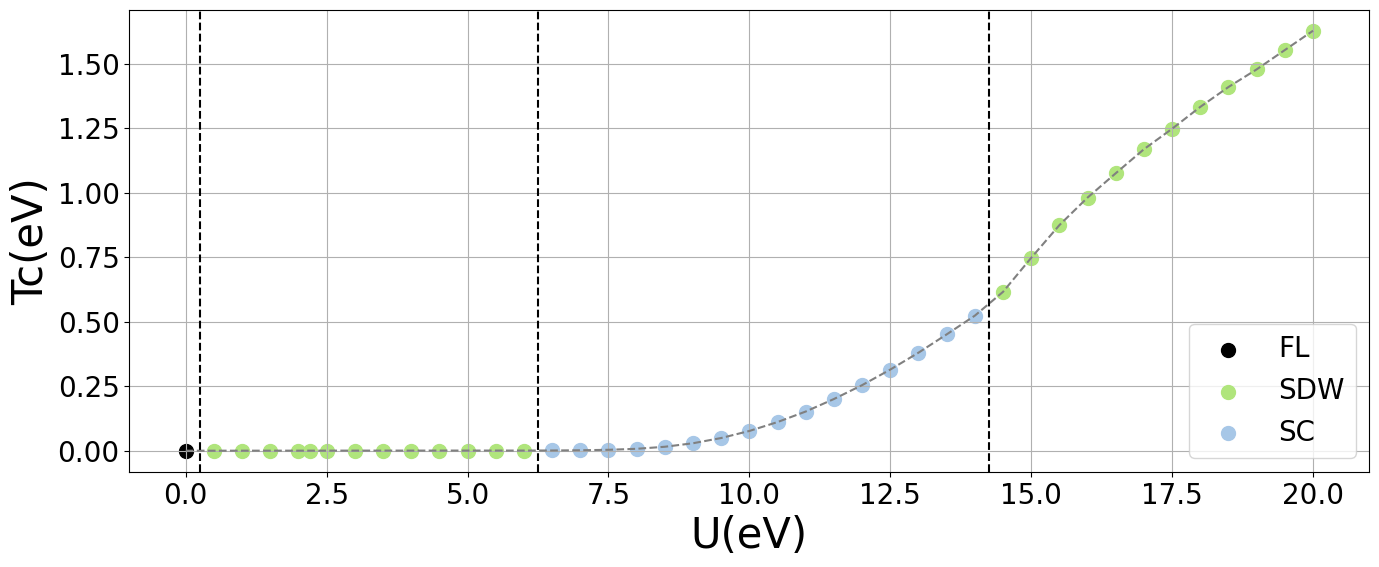

In [103]:
plot_Tc_mu("1NN_20_5_ff4_PhaseDiagram.log", 1.0)

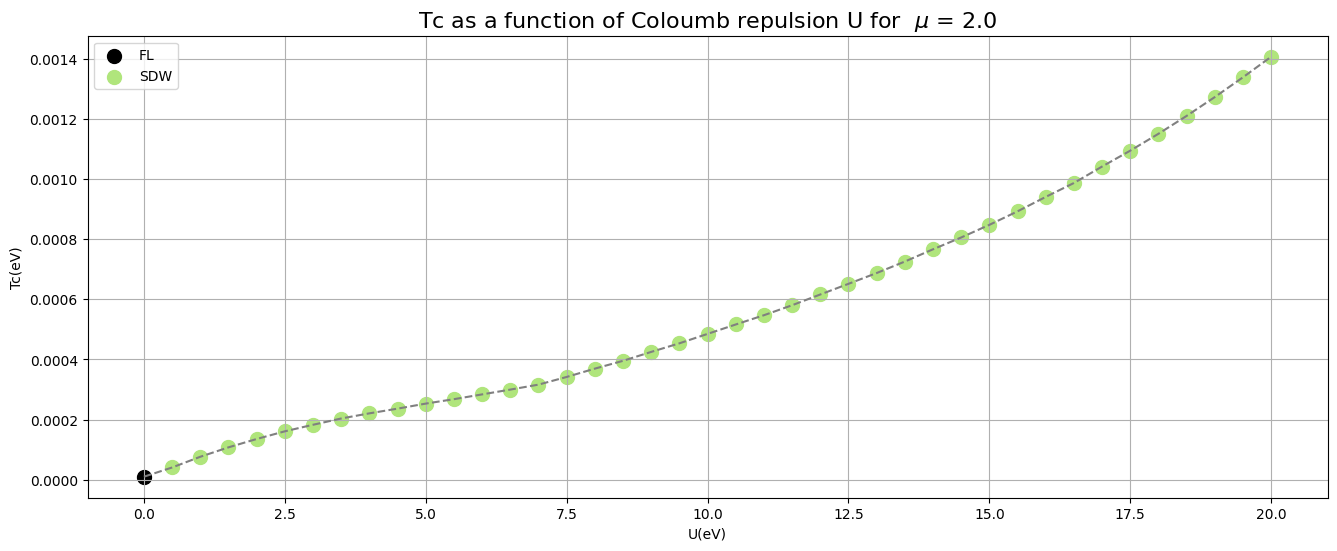

In [41]:
plot_Tc_mu("1NN_20_5_ff4_PhaseDiagram.log", 2.0)

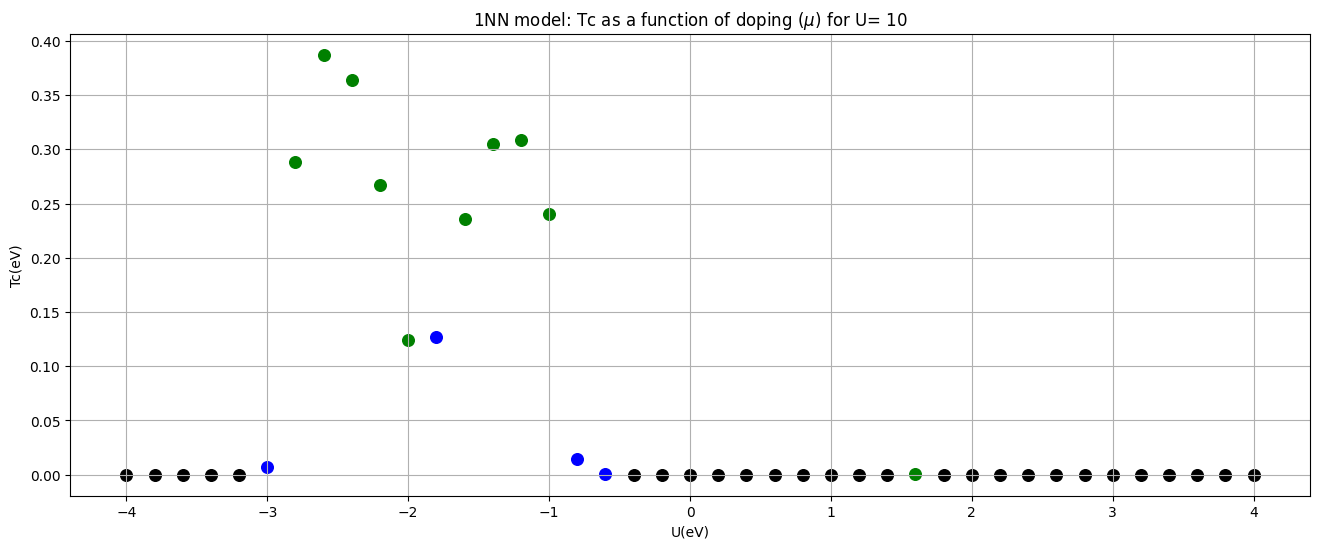

In [42]:
plot_Tc("1NNN_0p5_20_5_ff4_PhaseDiagram.log", 10)

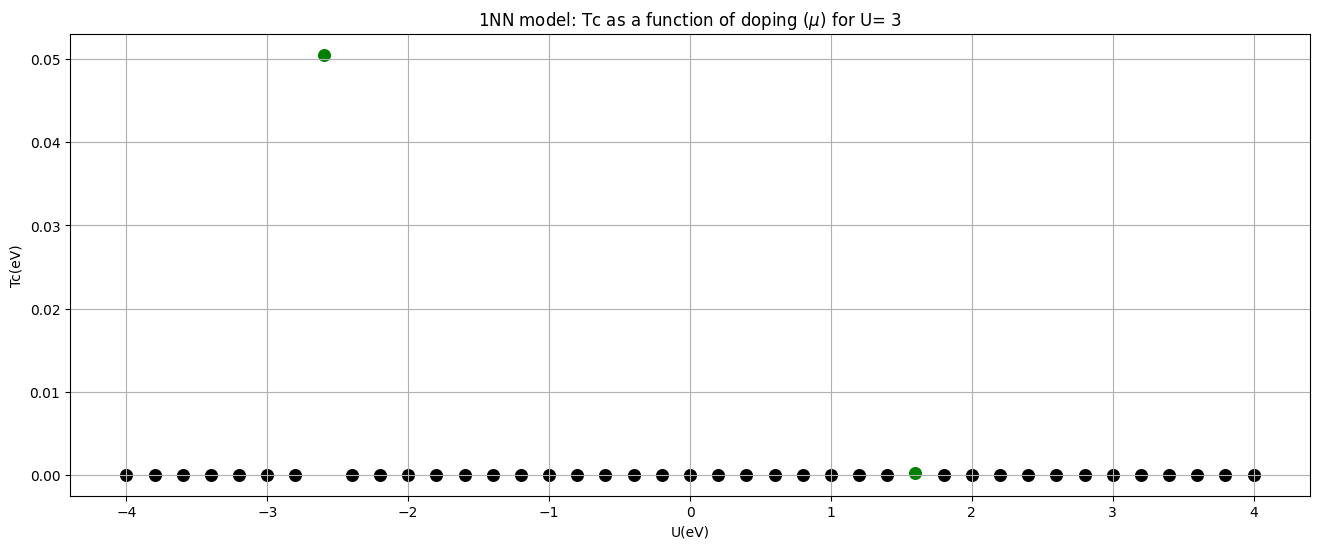

In [43]:
plot_Tc("1NNN_0p5_20_5_ff4_PhaseDiagram.log", 3)

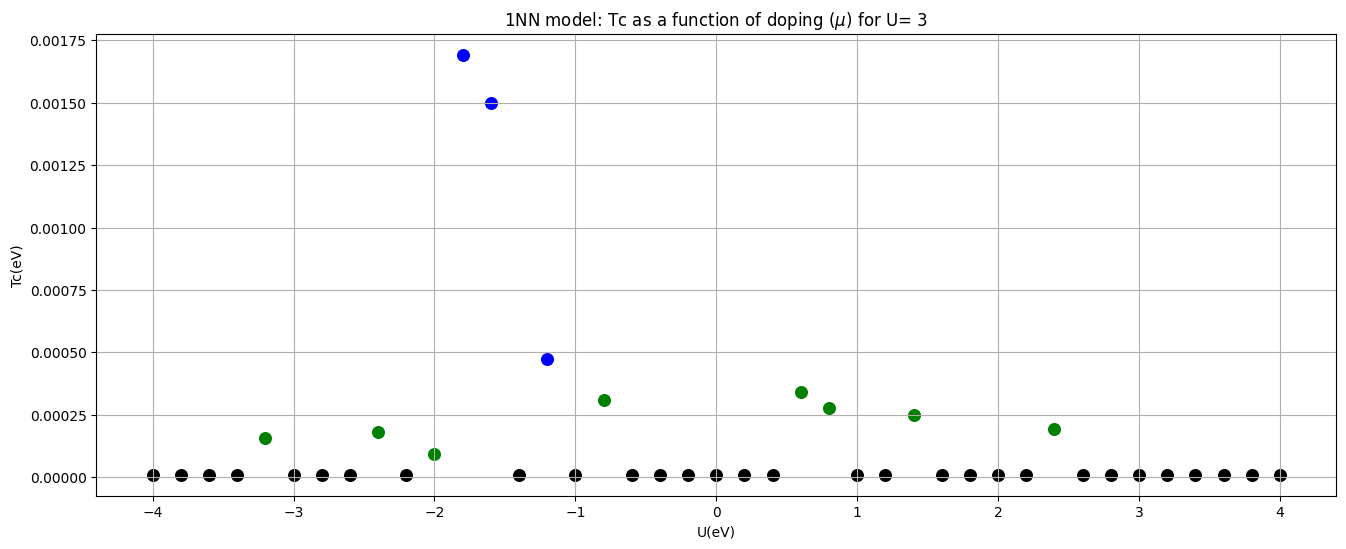

In [44]:
plot_Tc("1NNN_0p25_20_5_ff4_PhaseDiagram.log", 3)

# 1NNN Analysis

In [45]:
def plot_Tc_1NNN(data1,data2, data3,  U):

    #specify U for which th Tc is plotted 
    data = read_data(data1)
    data2 = read_data(data2)
    data3 = read_data(data3)

    groundstate = []
    Us = []
    mu = []
    points = []
    tc = []
    nk =[]
    nkf = []
    times = []
    for d in data:
        if d[0] == U:

            Us.append(d[0])
            mu.append(d[1])
            points.append([d[2],d[3]])  #nk, nkf vector
            groundstate.append(d[4])  #Stores GS
            nk.append(d[2])
            nkf.append(d[3])
            tc.append(d[5])  #stores Tc
            times.append(d[6])
    
    groundstate2 = []
    Us2 = []
    mu2 = []
    points2 = []
    tc2= [] 
    nk2 =[]
    nkf2 = []
    times2 = []
    for d in data2:
        if d[0] == U:

            Us2.append(d[0])
            mu2.append(d[1])
            points2.append([d[2],d[3]])  #nk, nkf vector
            groundstate2.append(d[4])  #Stores GS
            nk2.append(d[2])
            nkf2.append(d[3])
            tc2.append(d[5])  #stores Tc
            times2.append(d[6])


    groundstate3= []
    Us3= []
    mu3 = []
    points3 = []
    tc3 = []
    nk3 =[]
    nkf3 = []
    times3 = []
    for d in data3:
        if d[0] == U:

            Us3.append(d[0])
            mu3.append(d[1])
            points3.append([d[2],d[3]])  #nk, nkf vector
            groundstate3.append(d[4])  #Stores GS
            nk3.append(d[2])
            nkf3.append(d[3])
            tc3.append(d[5])  #stores Tc
            times3.append(d[6])

 
    fig, ax = plt.subplots(figsize=(16, 6))
    ax.grid()

    color_map = {
        "SC": "blue",
        "CDW": "orange",
        "FL": "black",
        "SDW": "green"
    }

    labels_added = {}

    for i in range(len(Us)):
        state = groundstate[i]
        colour = color_map.get(state, "white")

    # Add label only if it hasn't been added before
        label = state if state not in labels_added else None
        labels_added[state] = True  # Mark l abel as used
        ax.scatter(mu[i], tc[i], c=colour, s=70, marker="o")
    ax.plot(mu, tc, ls = "--", color = "grey", label = "t' =0.25")
    labels_added = {}
    tc2s = []
    tc3s = []

    for i in range(len(Us)):
        state = groundstate2[i]
        colour = color_map.get(state, "white")

    # Add label only if it hasn't been added before
        label = state if state not in labels_added else None
        labels_added[state] = True  # Mark label as used
        ax.scatter(mu2[i], tc2[i] + 0.01, c=colour, s=70, marker="x")
        tc2s.append(tc2[i]+0.01)
    ax.plot(mu2, tc2s, ls = "--", color = "red", label = "t' = 0.5")
    labels_added = {}
    
    for i in range(len(Us)):
        state = groundstate3[i]
        colour = color_map.get(state, "white")

    # Add label only if it hasn't been added before
        label = state if state not in labels_added else None
        labels_added[state] = True  # Mark label as used
        ax.scatter(mu3[i], tc3[i] + 0.02, c=colour, s=70, marker="v")
        tc3s.append(tc3[i]+0.02)
    ax.plot(mu3, tc3s, ls = "--", color = "yellow", label = "t' = 0.75")
        

    ax.set_xlabel(f"$\mu$(eV)")
    ax.legend()
    ax.set_ylabel("Tc(eV)")
    ax.set_title(f"1NN model: Tc as a function of doping ($\mu$) for U= {U}, for different t' amplitudes (offsetted by 0.01eV)")

    
 
    fig, ax = plt.subplots(figsize=(16, 6))

## 1NNNN Tc as a function of mu analysis

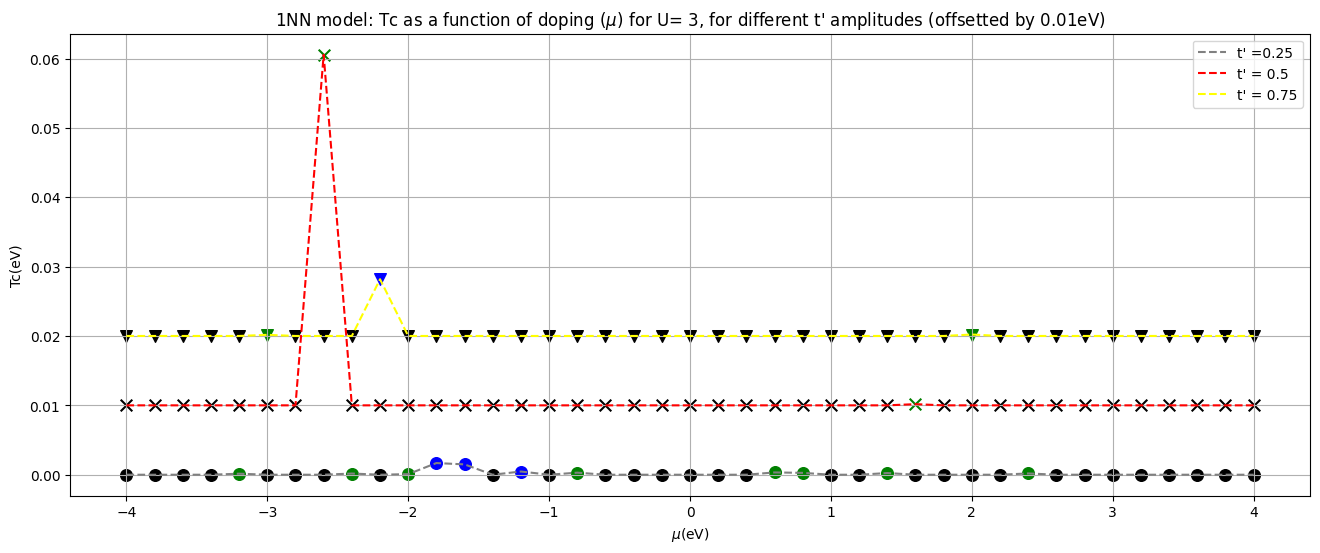

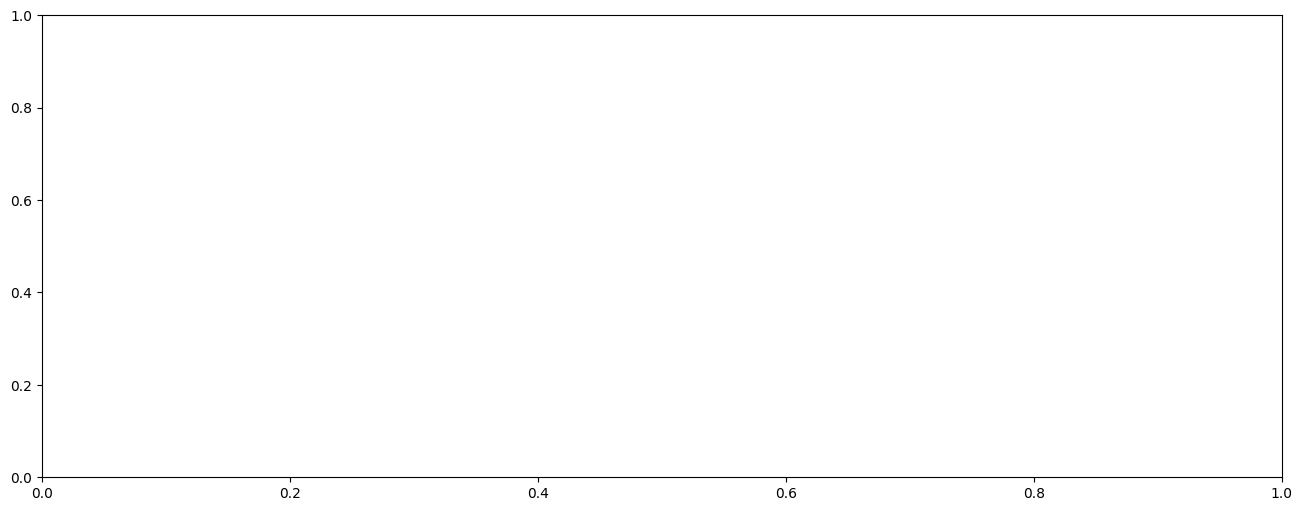

In [46]:
plot_Tc_1NNN("1NNN_0p25_20_5_ff4_PhaseDiagram.log", "1NNN_0p5_20_5_ff4_PhaseDiagram.log", "1NNN_0p75_20_5_ff4_PhaseDiagram.log", 3)

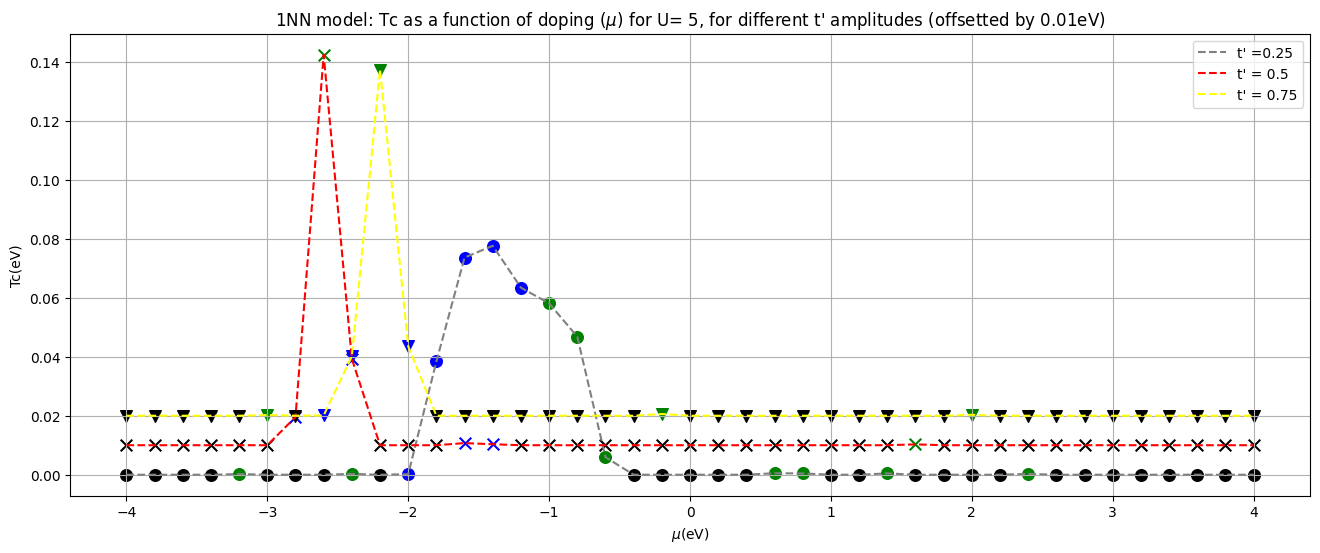

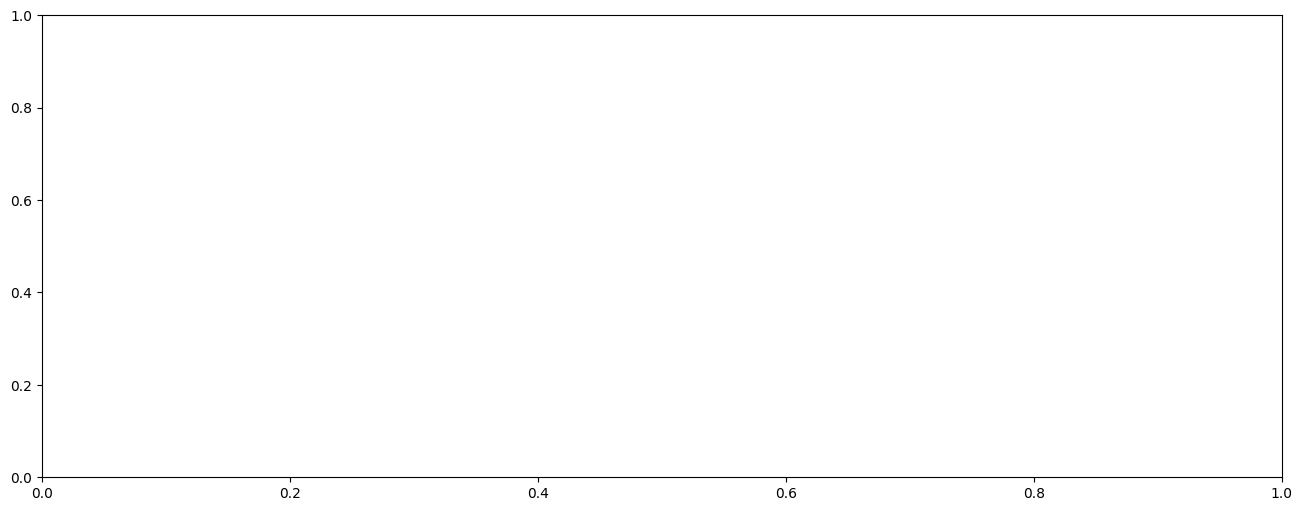

In [47]:
 plot_Tc_1NNN("1NNN_0p25_20_5_ff4_PhaseDiagram.log", "1NNN_0p5_20_5_ff4_PhaseDiagram.log", "1NNN_0p75_20_5_ff4_PhaseDiagram.log", 5)

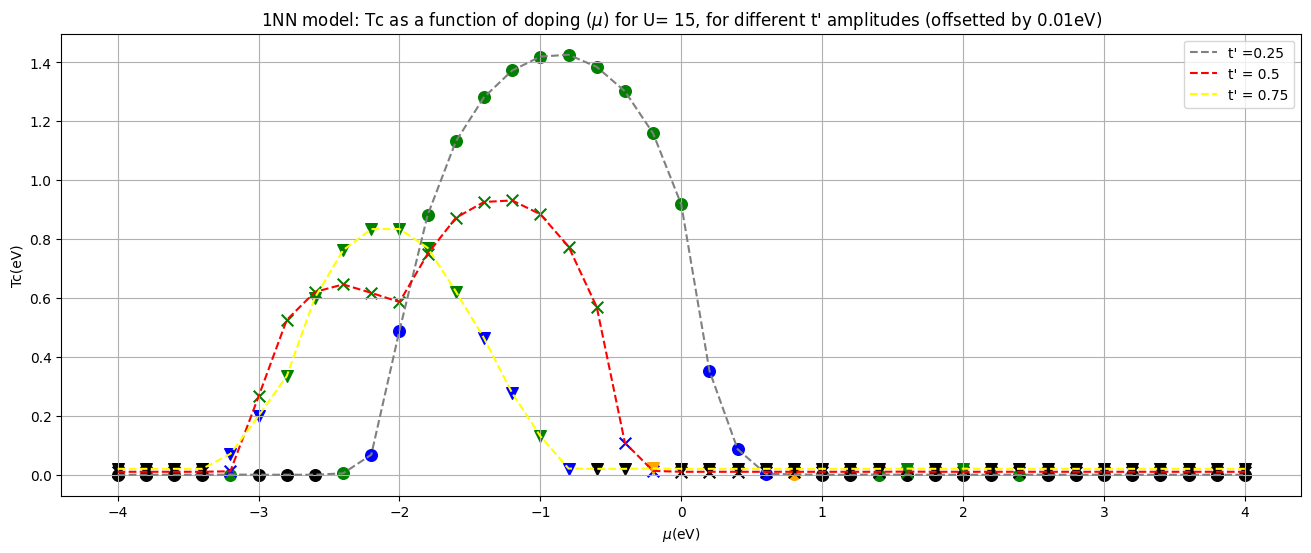

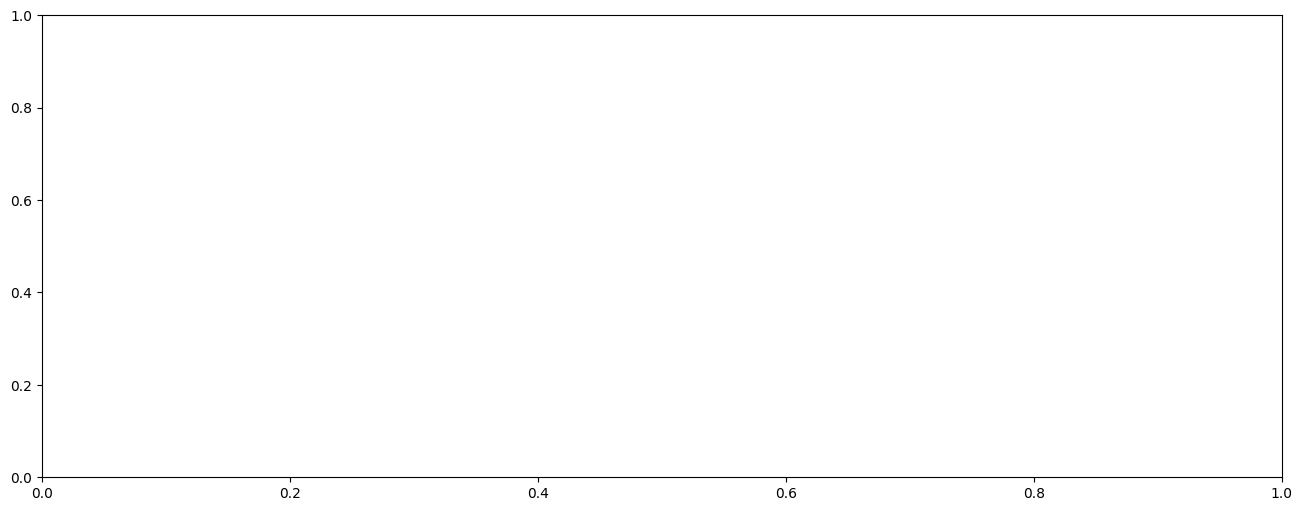

In [48]:
plot_Tc_1NNN("1NNN_0p25_20_5_ff4_PhaseDiagram.log", "1NNN_0p5_20_5_ff4_PhaseDiagram.log", "1NNN_0p75_20_5_ff4_PhaseDiagram.log", 15)

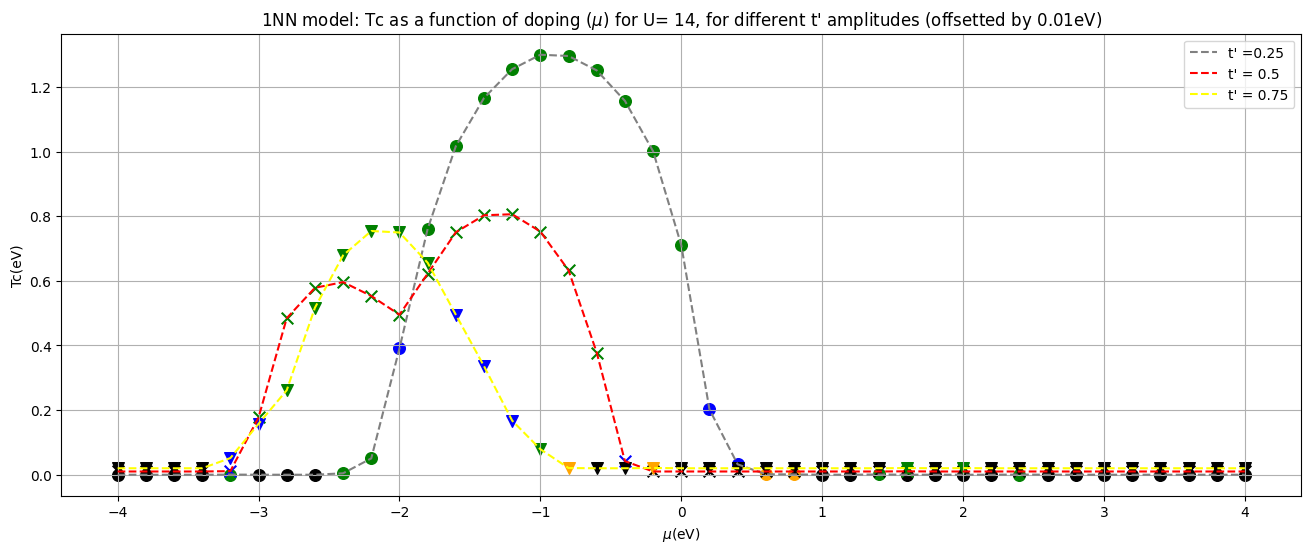

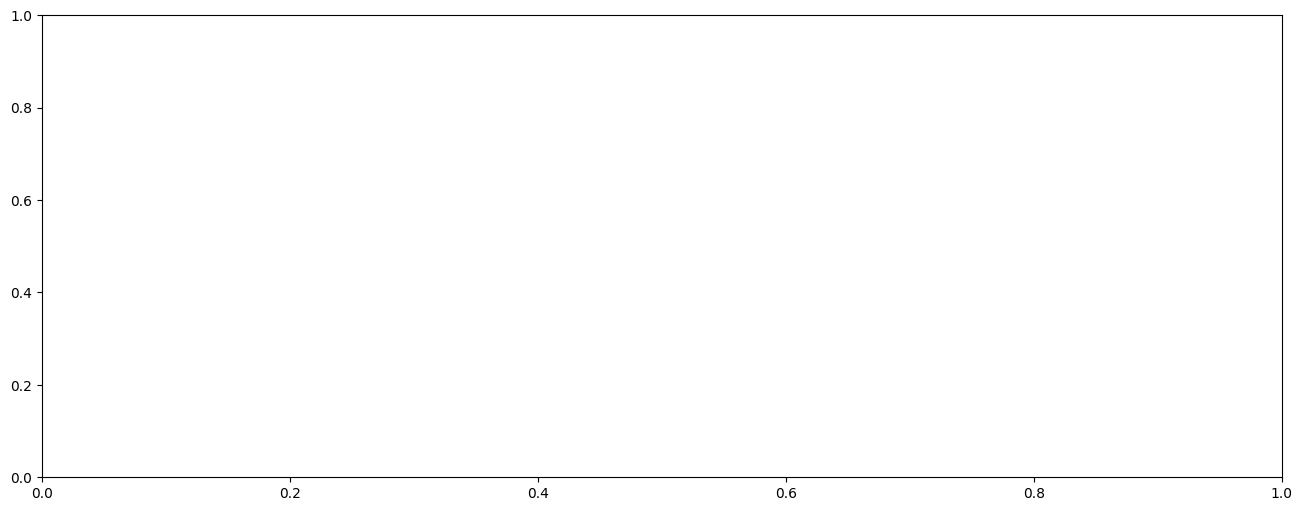

In [49]:
plot_Tc_1NNN("1NNN_0p25_20_5_ff4_PhaseDiagram.log", "1NNN_0p5_20_5_ff4_PhaseDiagram.log", "1NNN_0p75_20_5_ff4_PhaseDiagram.log", 14)


### Specific case of SDW in t' = 0.5


Questions to ask: 

- Is the double dome true of all Us
- Is the double dome a feature of this t' or present in all t's
- If present in other t's when does it occur?

In [50]:
def get_tcs_forU(data,U):
    groundstate = []
    Us = []
    mu = []
    points = []
    tc = []
    nk =[]
    nkf = []
    times = []
    for d in data:
        if d[0] == U:

            Us.append(d[0])
            mu.append(d[1])
            points.append([d[2],d[3]])  #nk, nkf vector
            groundstate.append(d[4])  #Stores GS
            nk.append(d[2])
            nkf.append(d[3])
            tc.append(d[5])  #stores Tc
            times.append(d[6])

    color_map = {
        "SC": "blue",
        "CDW": "orange",
        "FL": "black",
        "SDW": "green"
    }

    
    colours = []

    for i in range(len(Us)):
        state = groundstate[i]
        colours.append(color_map.get(state, "white"))
    
    return(mu, tc, colours)




    print(mus, tcs, colours)
    
    

In [51]:


Us = np.arange(10, 15, 0.5) 



def Tc_U_single(data, Us, model):
    hex_colors = [
        "#DC143C",  # Crimson
        "#FFD700",  # Gold
        "#4B0082",  # Indigo
        "#E6E6FA",  # Lavender
        "#FF00FF",  # Magenta
        "#FFE5B4",  # Peach
        "#DDA0DD",  # Plum
        "#E0115F",  # Ruby
        "#C0C0C0",  # Silver
        "#40E0D0"   # Turquoise
]   


 
    fig, ax = plt.subplots(figsize=(12, 10))
    ax.grid()

    for i,u in enumerate(Us):

        tcss =[]
    
        mus, tcs, colours = get_tcs_forU(data, u)
        for j in range(len(mus)):
            ax.scatter(mus[j], tcs[j] + i, color = colours[j], marker = 'x')
            tcss.append(tcs[j] + i )
        ax.plot(mus, tcss, ls= '--', color = hex_colors[i], label = f"U = {u}")

    ax.legend()

    ax.set_title(f"{model}. Tc as a function of $\mu$ for different U values(offsetted by 1) ")
    ax.set_xlabel(f"$\mu$ (eV)")
    ax.set_ylabel("Tc (eV)")

   









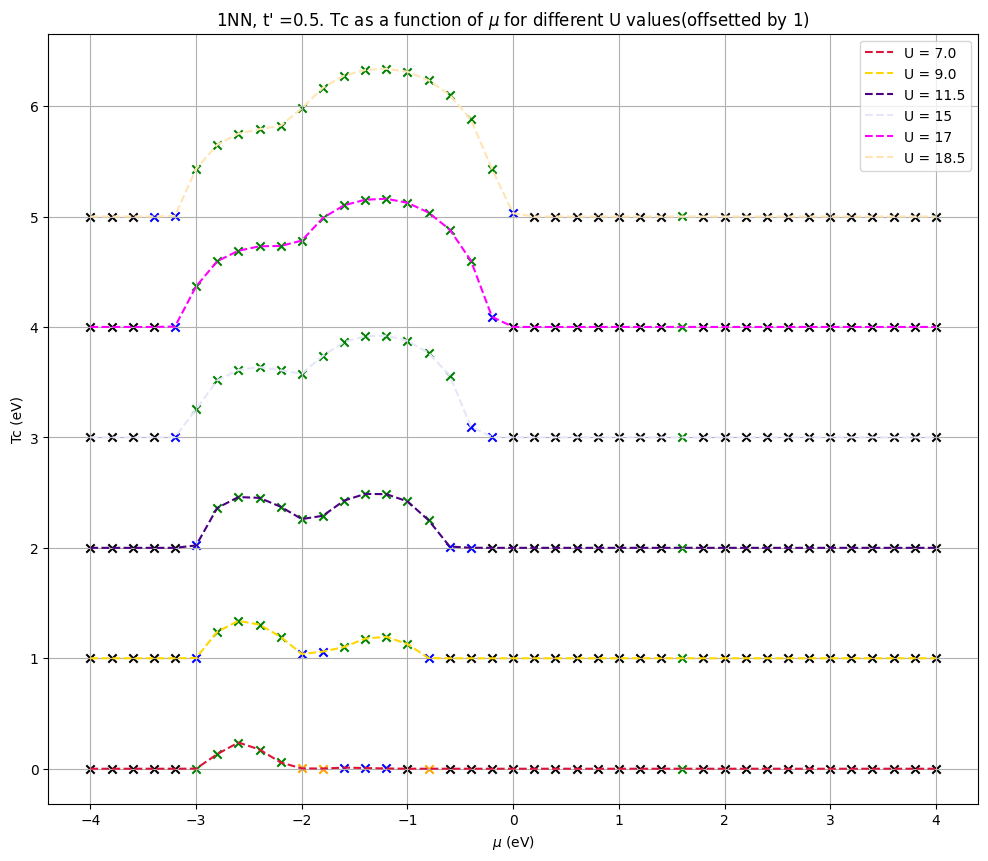

In [52]:
data =read_data("1NNN_0p5_20_5_ff4_PhaseDiagram.log")

Us = [7.0, 9.0, 11.5, 15, 17, 18.5 ]

Tc_U_single( data, Us, "1NN, t' =0.5")

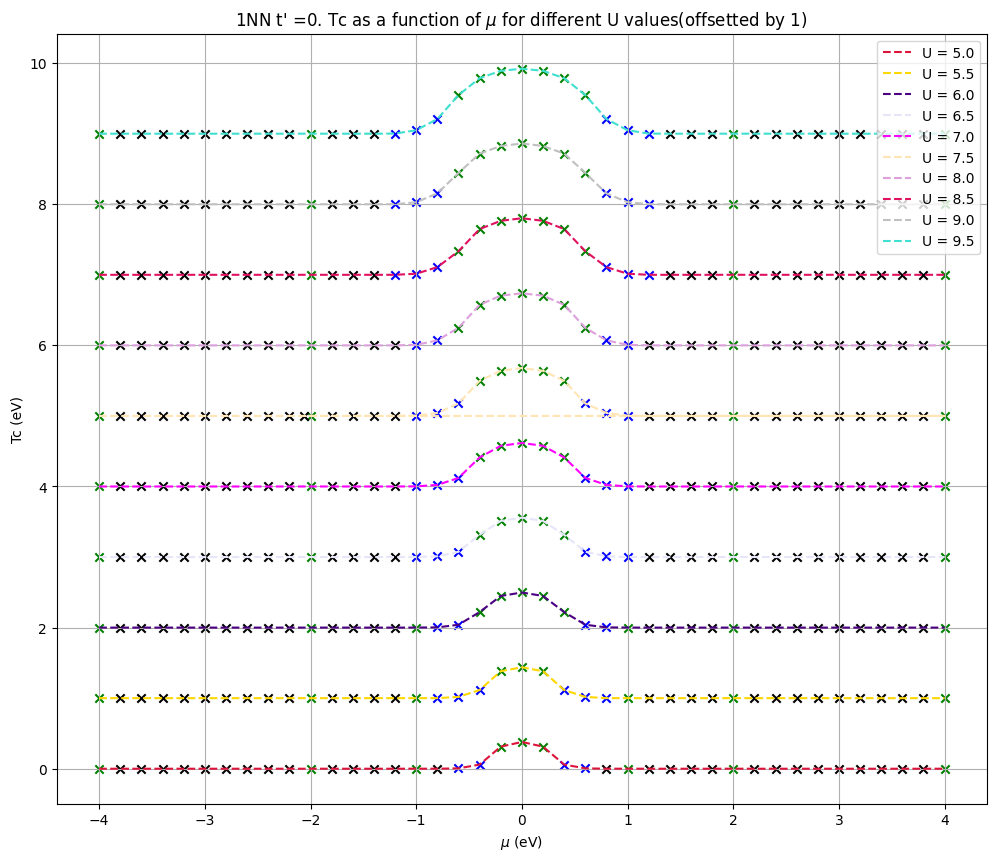

In [53]:
# look at the other models


data1 = read_data("1NN_20_5_ff4_PhaseDiagram.log")
Us = np.arange(5, 10, 0.5)

Tc_U_single( data1, Us, model = "1NN t' =0")



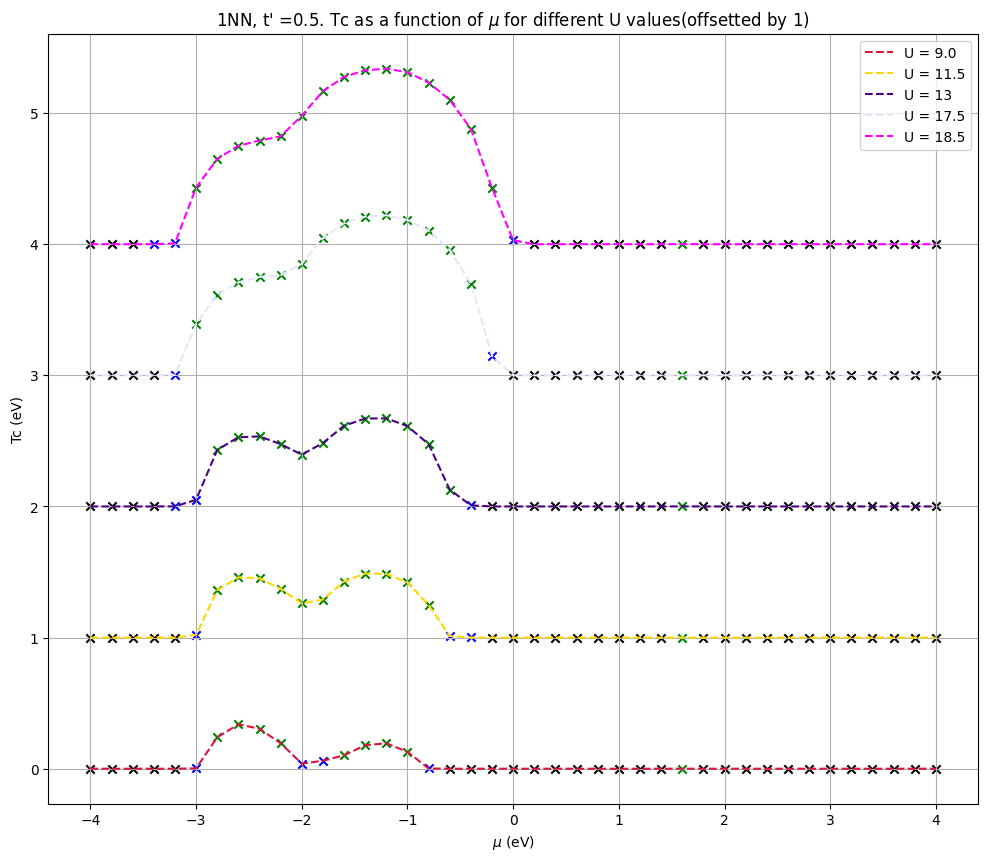

In [54]:
data =read_data("1NNN_0p5_20_5_ff4_PhaseDiagram.log")

Us = [9.0, 11.5, 13, 17.5,  18.5 ]

Tc_U_single( data, Us, "1NN, t' =0.5")

In [55]:
def plot_Tc_1NNN_mu(data1,data2, data3,  mus):

    #specify U for which th Tc is plotted 
    data = read_data(data1)
    data2 = read_data(data2)
    data3 = read_data(data3)

    groundstate = []
    Us = []
    mu = []
    points = []
    tc = []
    nk =[]
    nkf = []
    times = []
    for d in data:ax
        if d[1] == mus:

            Us.append(d[0])
            mu.append(d[1])
            points.append([d[2],d[3]])  #nk, nkf vector
            groundstate.append(d[4])  #Stores GS
            nk.append(d[2])
            nkf.append(d[3])
            tc.append(d[5])  #stores Tc
            times.append(d[6])
   
    
    
    groundstate2 = []
    Us2 = []
    mu2 = []
    points2 = []
    tc2= []
    nk2 =[]
    nkf2 = []
    times2 = []
    for d in data2:
        if d[1] == mus:

            Us2.append(d[0])
            mu2.append(d[1])
            points2.append([d[2],d[3]])  #nk, nkf vector
            groundstate2.append(d[4])  #Stores GS
            nk2.append(d[2])
            nkf2.append(d[3])
            tc2.append(d[5])  #stores Tc
            times2.append(d[6])


    groundstate3= []
    Us3= []
    mu3 = []
    points3 = []
    tc3 = []
    nk3 =[]
    nkf3 = []
    times3 = []
    for d in data3:
        if d[1] == mus:

            Us3.append(d[0])
            mu3.append(d[1])
            points3.append([d[2],d[3]])  #nk, nkf vector
            groundstate3.append(d[4])  #Stores GS
            nk3.append(d[2])
            nkf3.append(d[3])
            tc3.append(d[5])  #stores Tc
            times3.append(d[6])


    fig, ax = plt.subplots(figsize=(16, 6))
    ax.grid()

    color_map = {
        "SC": "blue",
        "CDW": "orange",
        "FL": "black",
        "SDW": "green"
    }

    labels_added = {}

    for i in range(len(mu)):
        state = groundstate[i]
        colour = color_map.get(state, "white")

    # Add label only if it hasn't been added before
        label = state if state not in labels_added else None
        labels_added[state] = True  # Mark label as used
        ax.scatter(Us[i], tc[i], c=colour, s=70, marker="o")
    ax.plot(Us, tc, ls = "--", color = "grey", label = "t' =0.25")
    labels_added = {}
    tc2s = []
    tc3s = []

    for i in range(len(mu2)):
        state = groundstate2[i]
        colour = color_map.get(state, "white")

    # Add label only if it hasn't been added before
        label = state if state not in labels_added else None
        labels_added[state] = True  # Mark label as used
        ax.scatter(Us2[i], tc2[i] + 0.01, c=colour, s=70, marker="x")
        tc2s.append(tc2[i]+0.01)
    ax.plot(Us2, tc2s, ls = "--", color = "red", label = "t' = 0.5")
    labels_added = {}
    
    for i in range(len(mu3)):
        state = groundstate3[i]
        colour = color_map.get(state, "white")

    # Add label only if it hasn't been added beforeplot_Tc_1NNN("1NNN_0p25_20_5_ff4_PhaseDiagram.log", "1NNN_0p5_20_5_ff4_PhaseDiagram.log", "1NNN_0p75_20_5_ff4_PhaseDiagram.log", 1)
        label = state if state not in labels_added else None
        labels_added[state] = True  # Mark label as used
        ax.scatter(Us3[i], tc3[i] + 0.02, c=colour, s=70, marker="v")
        tc3s.append(tc3[i]+0.02)
    ax.plot(Us3, tc3s, ls = "--", color = "yellow", label = "t' = 0.75")
        

    ax.set_xlabel(f"U(eV)")
    ax.legend()
    ax.set_ylabel("Tc(eV)")
    ax.set_title(f"1NN model: Tc as a function of doping ($\mu$) for $\mu$= {mus}, for different t' amplitudes (offsetted by 0.01eV)")

    


IndentationError: unexpected indent (1609324686.py, line 17)

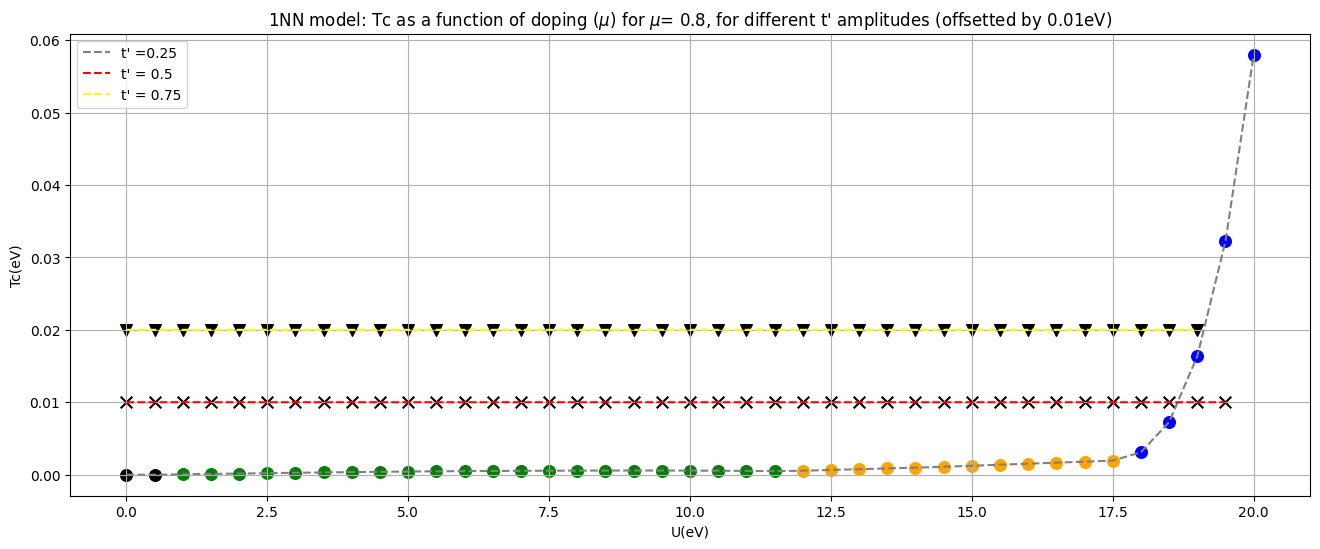

In [55]:
plot_Tc_1NNN_mu("1NNN_0p25_20_5_ff4_PhaseDiagram.log", "1NNN_0p5_20_5_ff4_PhaseDiagram.log", "1NNN_0p75_20_5_ff4_PhaseDiagram.log", 0.8)


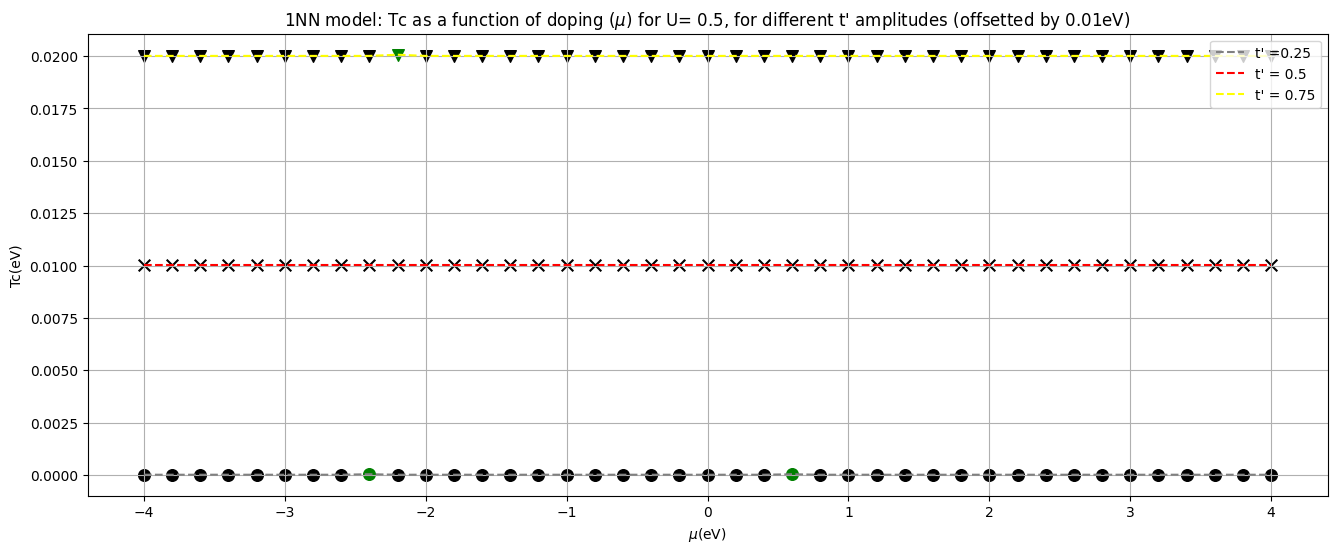

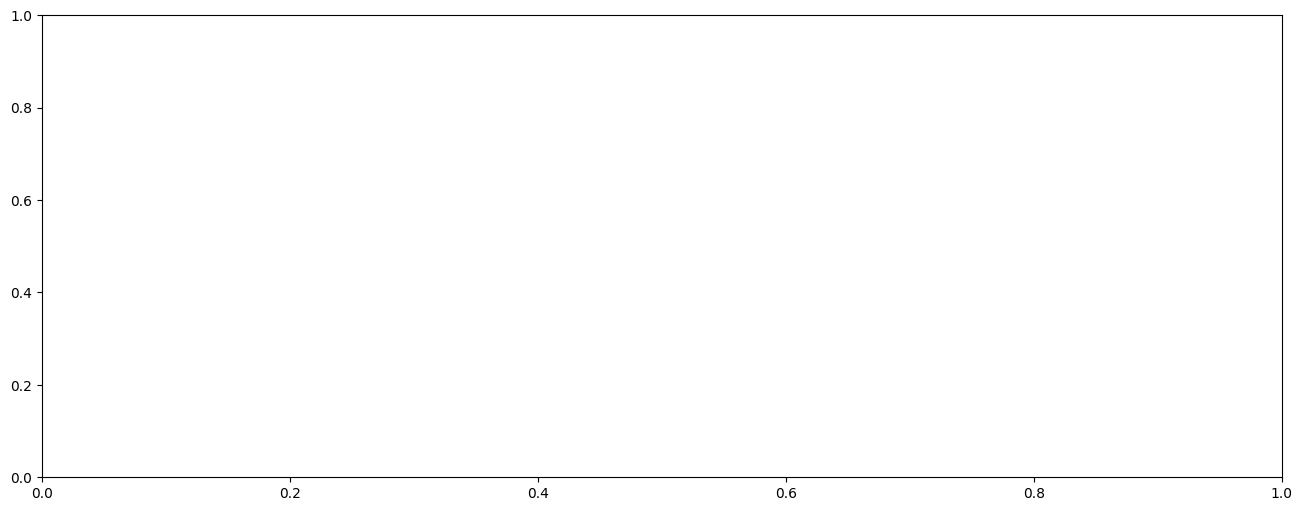

In [56]:
plot_Tc_1NNN("1NNN_0p25_20_5_ff4_PhaseDiagram.log", "1NNN_0p5_20_5_ff4_PhaseDiagram.log", "1NNN_0p75_20_5_ff4_PhaseDiagram.log", 0.5)

In [56]:
#plot divereging 

import numpy as np

def read_columns(file_name):
    column1, column2, column3, column4 = [], [], [], []
    
    with open(file_name, 'r') as file:
        for line in file:
            values = line.split()
            if len(values) >= 4:  # Ensure there are at least 4 columns
                column1.append(float(values[0]))
                column2.append(float(values[1]))
                column3.append(float(values[2]))
                column4.append(float(values[3]))
    
    return np.array(column1), np.array(column2), np.array(column3), np.array(column4)

# Example usage
 # Replace with the actual file name
    


Text(0.5, 0, 'Calculation steps')

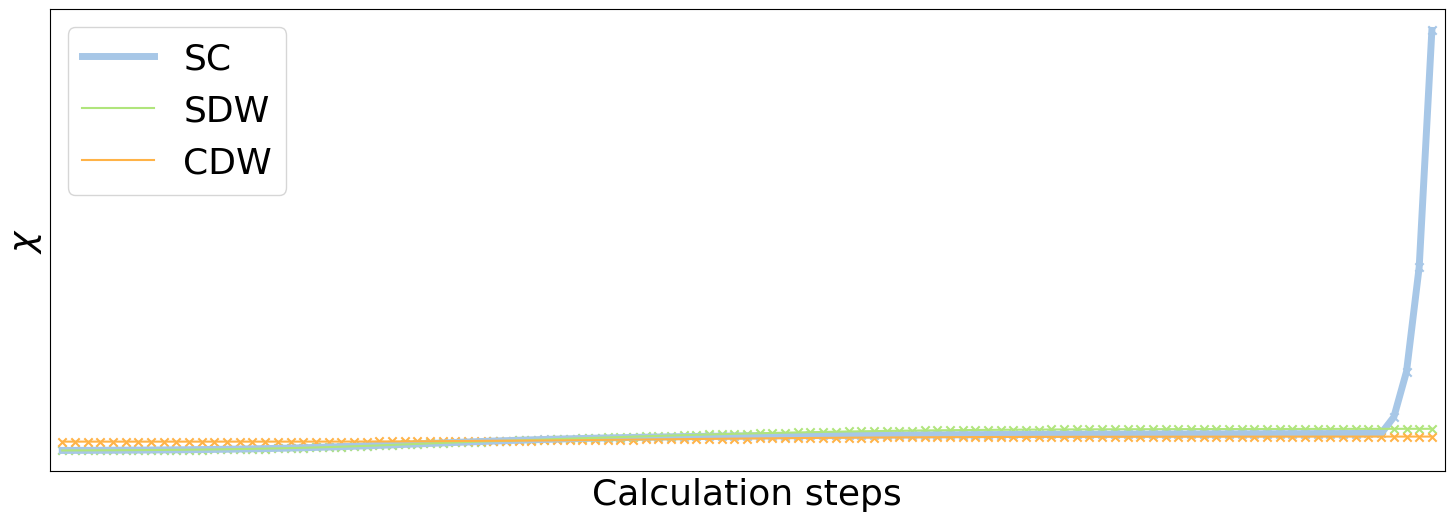

In [60]:
file_name = '1NNa_6.00_0.9_20_5.txt' 
tc, sc, sdw, cdw = read_columns(file_name)

s = len(tc)

num = np.arange(1,s+1)


fig, ax = plt.subplots(figsize = (18,6))

ax.plot(num, sc, color = '#A7C7E7', label ="SC", linewidth = 5)
ax.scatter(num,  sc, color = '#A7C7E7', marker ='x')
ax.plot(num, sdw, color = '#B0E57C', label ="SDW")
ax.scatter(num, sdw, color = '#B0E57C', marker = 'x')
ax.plot(num, cdw, color = '#FFB347', label ="CDW")
ax.scatter(num, cdw, color = '#FFB347', marker = 'x')
ax.legend(fontsize = 26)
ax.grid()
ax.set_xlim(0, s+1)
plt.xticks([])  # Hide x-axis labels
plt.yticks([])
ax.set_ylabel(r"$\chi$", size = 26)
ax.set_xlabel("Calculation steps", size = 26)
#ax.set_title("FRG calculation of the three channel susceptibilities ", size =20)

